# DataSci 207 Final Project: Credit Score Classification #

## Step 1: Import libraries ##

In [ ]:
import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
import tensorflow as tf
from matplotlib import pyplot as plt
import keras_tuner as kt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

from scipy.stats import chi2_contingency

## Step 2: Download data files from source link then unzip ##

(No need to manually re-upload data files to notebook each time)

In [ ]:
!curl -L -o ./data.zip https://www.kaggle.com/api/v1/datasets/download/parisrohan/credit-score-classification

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 9739k  100 9739k    0     0  12.5M      0 --:--:-- --:--:-- --:--:-- 12.5M


In [ ]:
!unzip -o data.zip

Archive:  data.zip
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
# raw training data variable: df_train
df_train = pd.read_csv('/content/train.csv', sep=',')
df_train.dtypes

<ipython-input-21-15072c0c4022>:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('/content/train.csv', sep=',')


,0
ID,object
Customer_ID,object
Month,object
Name,object
Age,object
SSN,object
Occupation,object
Annual_Income,object
Monthly_Inhand_Salary,float64
Num_Bank_Accounts,int64


## Step 3: (EDA 1) Explore dataset, examine initial distributions

Many of the raw columns are not visualizable without cleaning due to malformed data in the columns

In [ ]:
# Convert dtypes to DataFrame
df_types = pd.DataFrame(df_train.dtypes, columns=['Type']).reset_index()
df_types.columns = ['Column', 'Type']
print(df_types)

                      Column     Type
0                         ID   object
1                Customer_ID   object
2                      Month   object
3                       Name   object
4                        Age   object
5                        SSN   object
6                 Occupation   object
7              Annual_Income   object
8      Monthly_Inhand_Salary  float64
9          Num_Bank_Accounts    int64
10           Num_Credit_Card    int64
11             Interest_Rate    int64
12               Num_of_Loan   object
13              Type_of_Loan   object
14       Delay_from_due_date    int64
15    Num_of_Delayed_Payment   object
16      Changed_Credit_Limit   object
17      Num_Credit_Inquiries  float64
18                Credit_Mix   object
19          Outstanding_Debt   object
20  Credit_Utilization_Ratio  float64
21        Credit_History_Age   object
22     Payment_of_Min_Amount   object
23       Total_EMI_per_month  float64
24   Amount_invested_monthly   object
25         P

In [ ]:
# Get list of non-object columns
non_object_cols = df_train.select_dtypes(exclude=['object']).columns.tolist()
print("Columns with non-object dtype:")
print(non_object_cols)

Columns with non-object dtype:
['Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date', 'Num_Credit_Inquiries', 'Credit_Utilization_Ratio', 'Total_EMI_per_month']


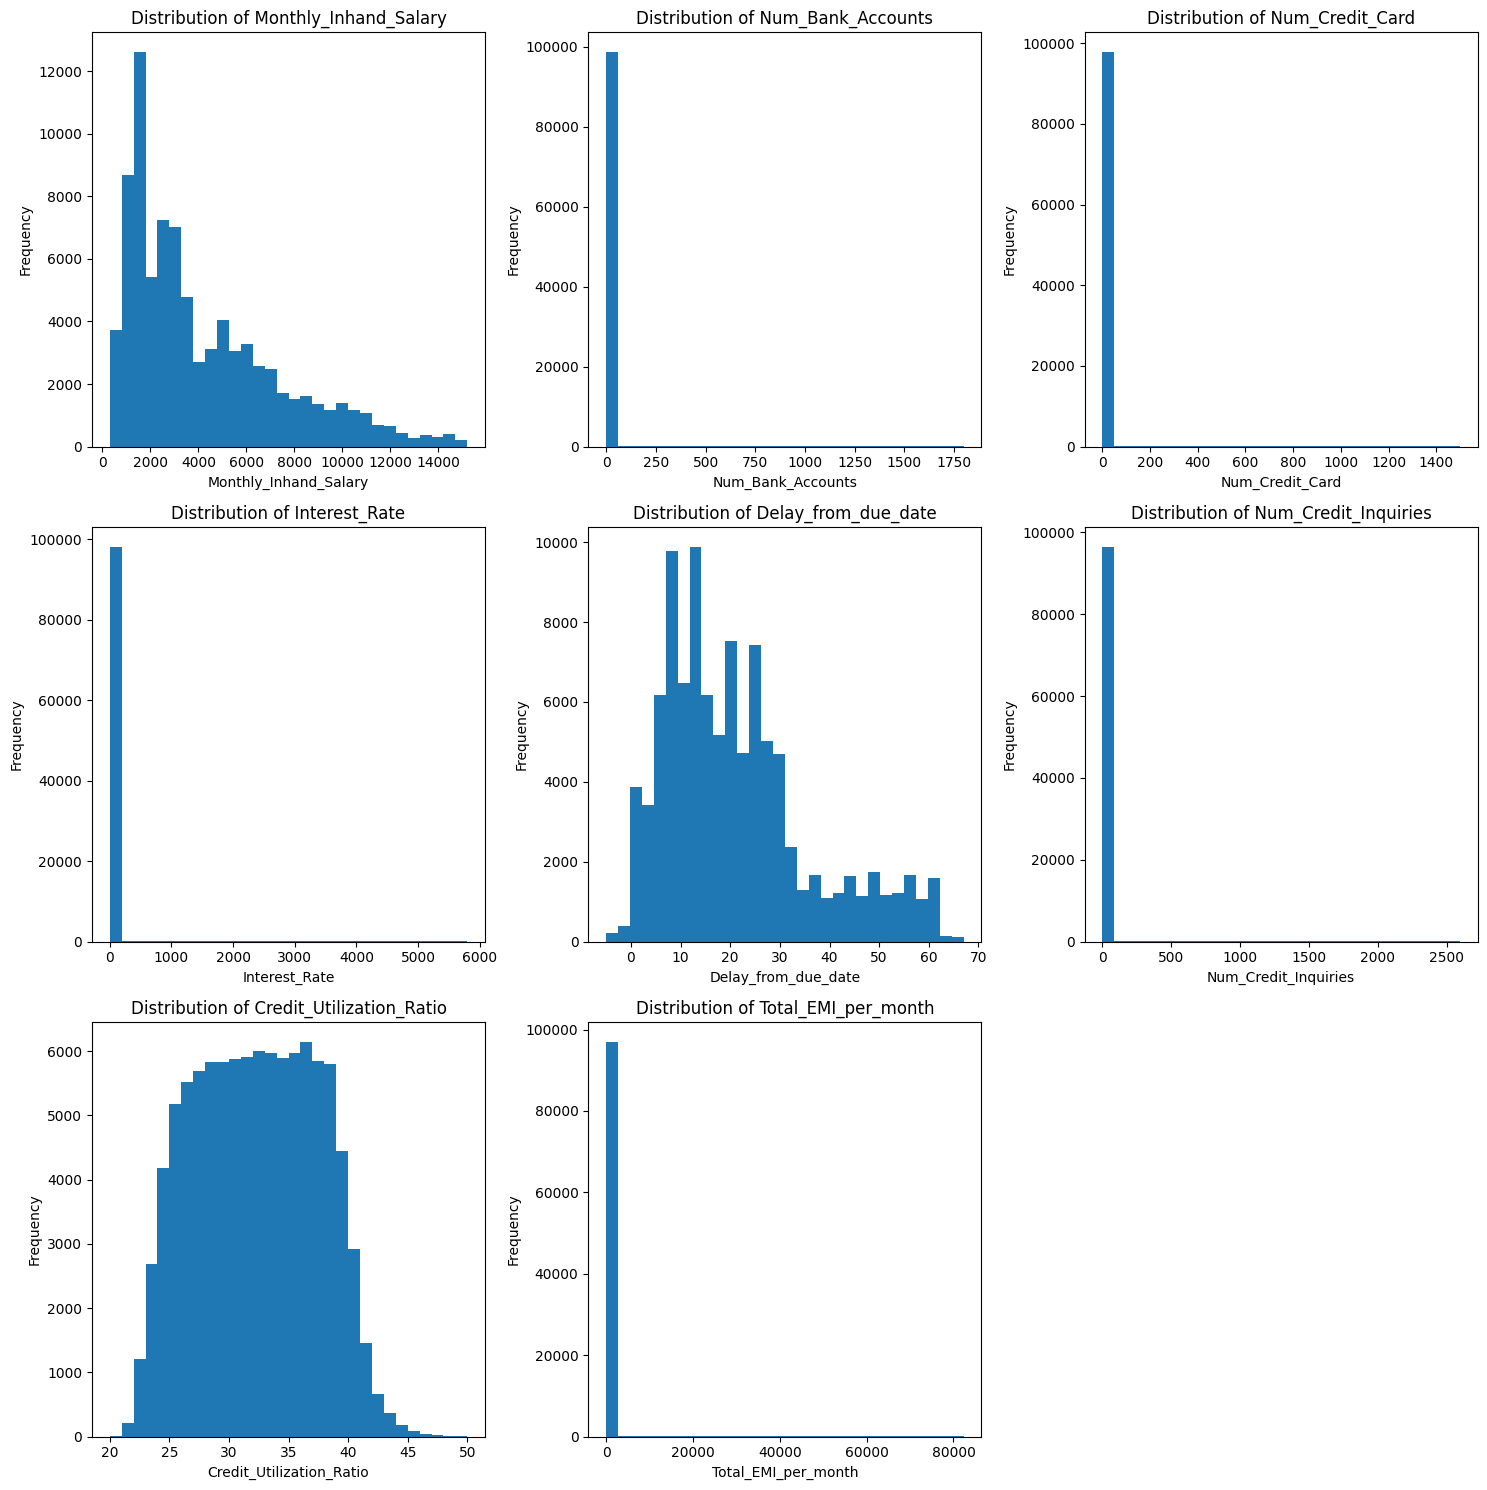

In [ ]:
# Calculate number of rows needed for subplot grid
n_cols = len(non_object_cols)
n_rows = (n_cols + 2) // 3  # 3 columns per row, rounded up

# Create subplot grid
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Create histograms for each non-object column
for i, col in enumerate(non_object_cols):
    axes[i].hist(df_train[col], bins=30)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots
for i in range(n_cols, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [ ]:
# Get list of object columns
object_cols = df_train.select_dtypes(include=['object']).columns.tolist()
print("Columns with object dtype:")
print(object_cols)

Columns with object dtype:
['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation', 'Annual_Income', 'Num_of_Loan', 'Type_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Credit_Mix', 'Outstanding_Debt', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance', 'Credit_Score']


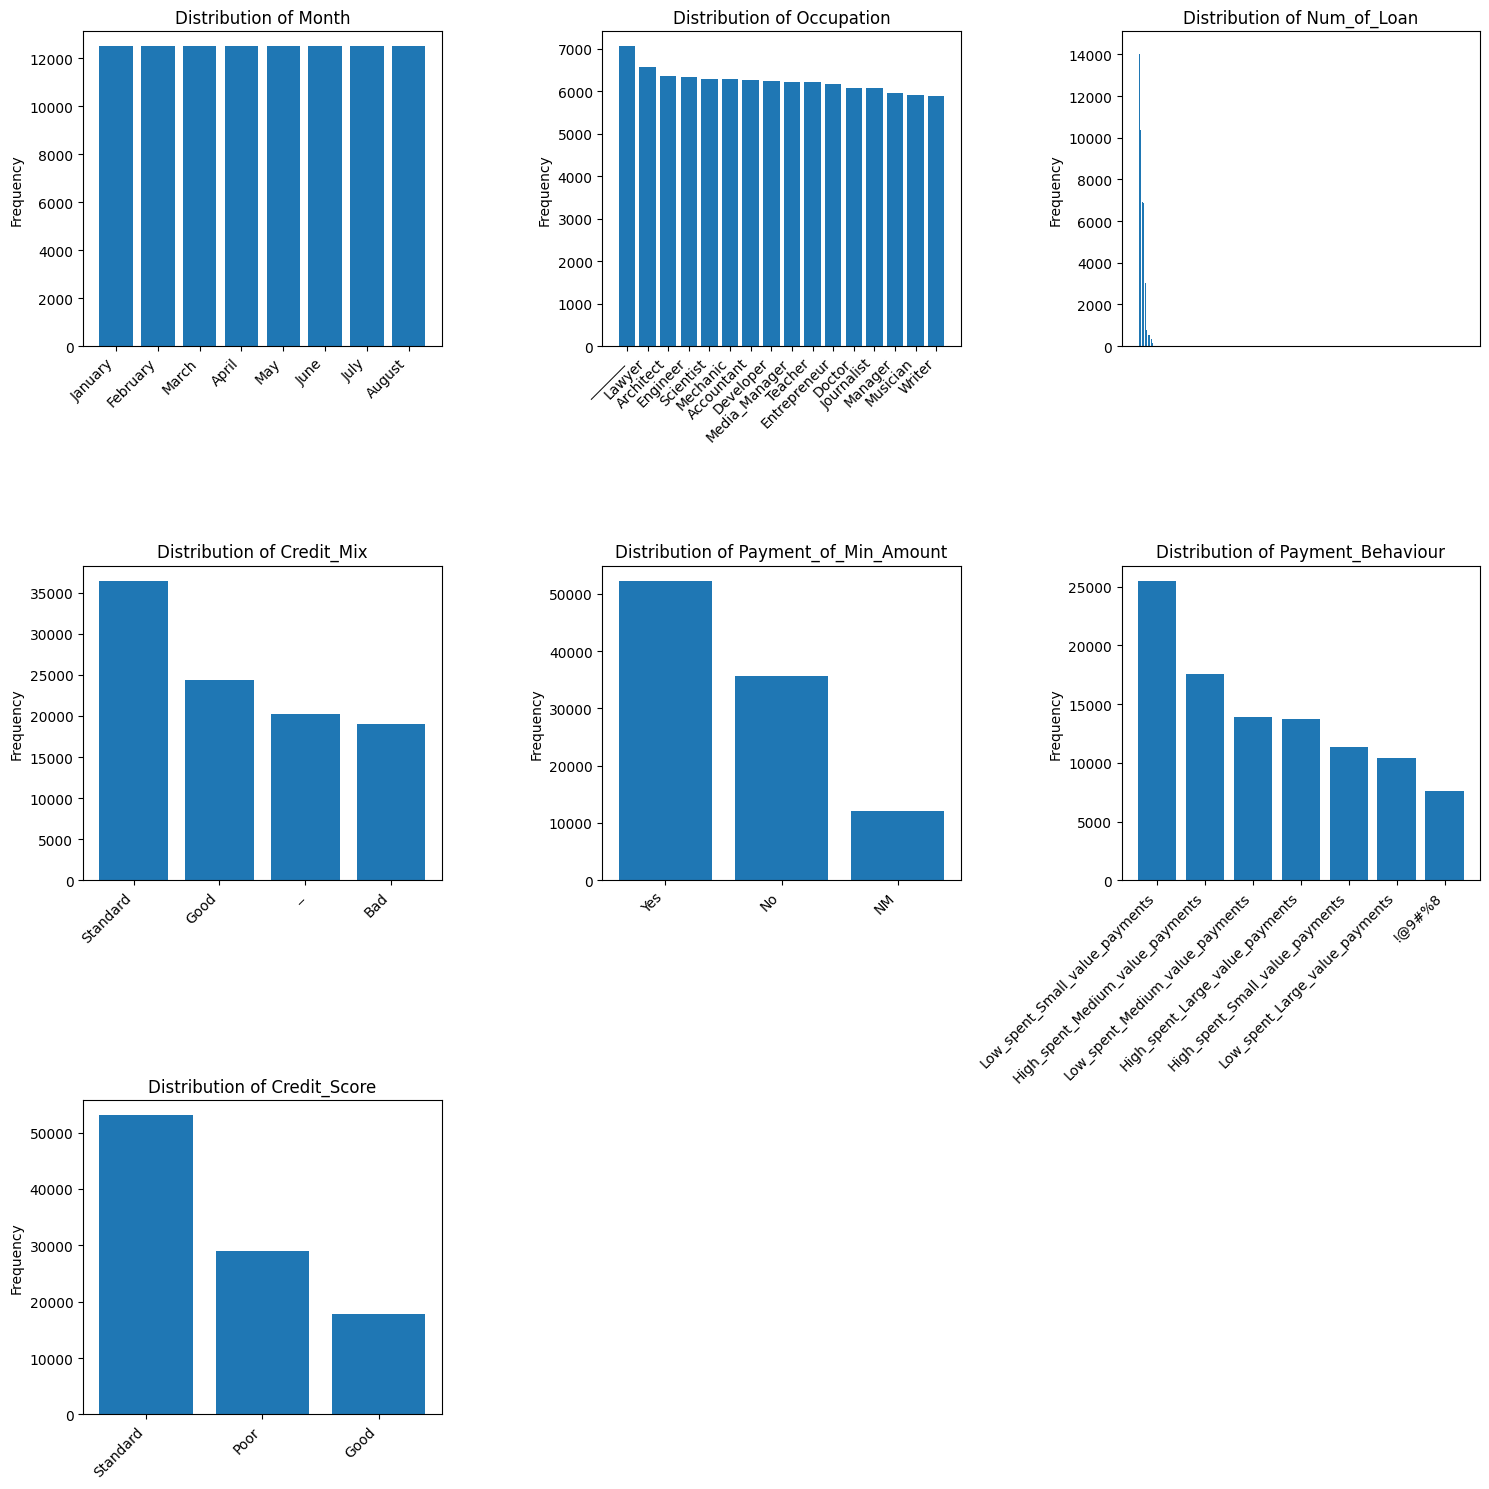

In [ ]:
# object columns
a=[2,6,8,12,15,17,19]
object_cols_hist = [object_cols[i] for i in a]

# Calculate number of rows needed for subplot grid
n_cols = len(object_cols_hist)
n_rows = (n_cols + 2) // 3  # 3 columns per row, rounded up

# Create subplot grid
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Create histograms/bar plots for each selected object column
for i, col in enumerate(object_cols_hist):
    value_counts = df_train[col].value_counts()
    axes[i].bar(range(len(value_counts)), value_counts.values)
    axes[i].set_title(f'Distribution of {col}')
    if len(value_counts) > 30:  # If too many categories, skip x labels
        axes[i].set_xticks([])
    else:
        axes[i].set_xticks(range(len(value_counts)))
        axes[i].set_xticklabels(value_counts.index, rotation=45, ha='right')
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots
for i in range(n_cols, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [ ]:
# Get indices not included in histogram
remaining_indices = [i for i in range(len(object_cols)) if i not in a]
remaining_cols = [object_cols[i] for i in remaining_indices]

# Show value counts for each remaining column
for col in remaining_cols:
    print(f"\nValue counts for {col}:")
    print(df_train[col].value_counts())
    print("-" * 50)  # Separator line


Value counts for ID:
ID
0x1602     1
0x19c88    1
0x19caa    1
0x19ca5    1
0x19ca4    1
          ..
0xd94d     1
0xd94c     1
0xd94b     1
0xd94a     1
0x25fed    1
Name: count, Length: 100000, dtype: int64
--------------------------------------------------

Value counts for Customer_ID:
Customer_ID
CUS_0xd40     8
CUS_0x9bf4    8
CUS_0x5ae3    8
CUS_0xbe9a    8
CUS_0x4874    8
             ..
CUS_0x2eb4    8
CUS_0x7863    8
CUS_0x9d89    8
CUS_0xc045    8
CUS_0x942c    8
Name: count, Length: 12500, dtype: int64
--------------------------------------------------

Value counts for Name:
Name
Langep            44
Stevex            44
Vaughanl          39
Jessicad          39
Raymondr          38
                  ..
Alina Selyukhg     4
Habboushg          4
Mortimerq          4
Ronaldf            4
Timothyl           3
Name: count, Length: 10139, dtype: int64
--------------------------------------------------

Value counts for Age:
Age
38      2833
28      2829
31      2806
26      27

## Step 4: Clean and preprocess datasets ##

Eun-Hae
* ID: Unique for each row. Not much use for modelling.
* Customer_ID
* Month: No need for cleaning. Equally distributed. Training (Jan.-Aug.) and test (Sep.-Dec.) set cover different months.
* Name: Don't see much use.
* Age: Cleaned and created Age10 feature.
* SSN: Need to discard.
* Occupation: Cleaned.

In [ ]:
# null counts for data set
null_counts_train = df_train.isnull().sum()
print(f'Length of dataset: {len(df_train)}')
print('Null Counts:')
print(null_counts_train)

Length of dataset: 100000
Null Counts:
ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: in

In [ ]:
# Training set includes Jan.-Aug. Distribution of data is equal (12,500 each)
print("Training Dataset:")
print(df_train["Month"].value_counts())

Training Dataset:
Month
January     12500
February    12500
March       12500
April       12500
May         12500
June        12500
July        12500
August      12500
Name: count, dtype: int64


In [ ]:
# There are values with understore attached at the end, errors (values larger than 100), missing values (-500)
value_counts_train_age = df_train.Age.value_counts().reset_index()
value_counts_train_age


,Age,count
0,38,2833
1,28,2829
2,31,2806
3,26,2792
4,32,2749
...,...,...
1783,471,1
1784,1520,1
1785,8663,1
1786,3363,1


In [ ]:
# Step 1: Remove underscores from the 'age' column
df_train['Age'] = df_train['Age'].str.replace('_', '', regex=True)
# Step 2: Convert the 'age' column to numeric
df_train['Age'] = pd.to_numeric(df_train['Age'], errors='coerce')
# Step 3: Filter out invalid ages (values < 0 or > 100)
df_train.loc[df_train['Age'] > 100, 'Age'] = None
df_train.loc[df_train['Age'] < 0, 'Age'] = None


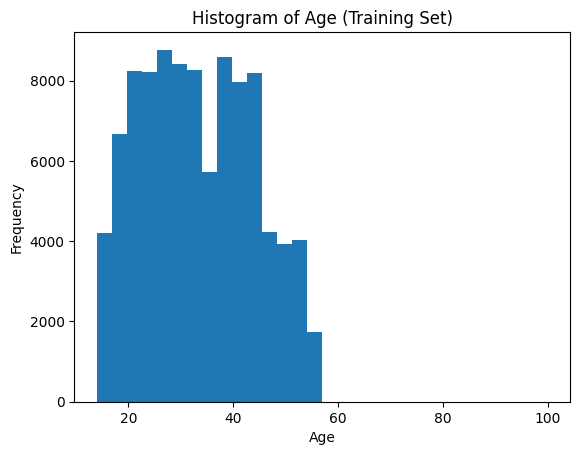

In [ ]:
plt.hist(df_train['Age'], bins=30)
plt.title('Histogram of Age (Training Set)')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Age10: Create a new ordered variable for age
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # Define bins for each decade
labels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # Labels for decades (e.g. [10, 20) => 10)

df_train['Age10'] = pd.cut(df_train['Age'], bins=bins, labels=labels, right=False)

In [ ]:
# should we leave age 90+ or treat them as "None"
print("Training Set:")
print(df_train.Age10.value_counts())

Training Set:
Age10
30    28262
20    27981
40    21779
10    10884
50     8313
90        4
0         0
60        0
70        0
80        0
Name: count, dtype: int64


In [ ]:
# Occupation "_______" seems like it's missing values
print("Training Set:")
print(df_train.Occupation.value_counts())
# Filter out invalid occupation
df_train.loc[df_train['Occupation'] == "_______", 'Occupation'] = None

Training Set:
Occupation
_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: count, dtype: int64


<Axes: xlabel='Age10'>

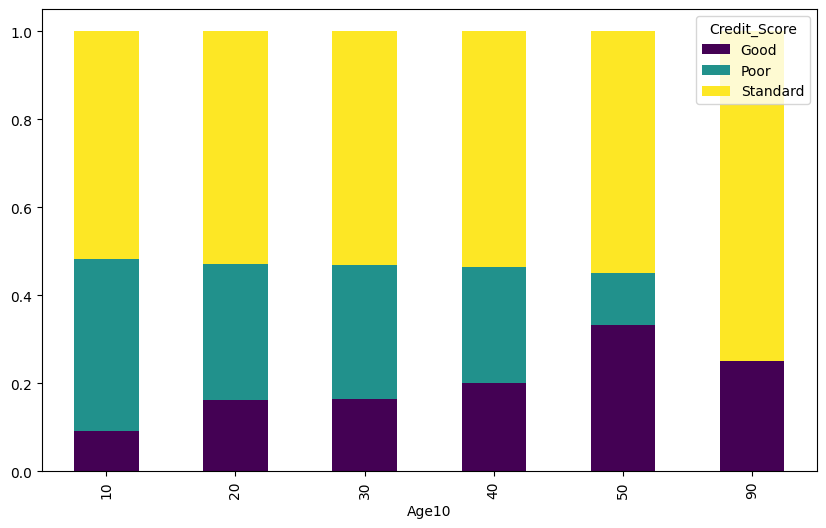

In [ ]:
pivot_table = pd.crosstab(df_train['Age10'], df_train['Credit_Score'])
pivot_table_normalized = pivot_table.div(pivot_table.sum(axis=1), axis=0)
pivot_table_normalized.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

Ben: Preprocess following variables in both train and test datasets
```
Annual_Income
Monthly_Inhand_Salary
Num_Bank_Accounts
Num_Credit_Card
Interest_Rate
Num_of_Loan
Type_of_Loan
Credit_Score
```


check for underscores and removable characters in columns, also check for how many negative values are in the columns

In [ ]:
# checking values in the training columns
non_convertible_values = df_train['Num_of_Loan'].apply(pd.to_numeric, errors='coerce').isna()
unique_non_numeric = df_train.loc[non_convertible_values, 'Num_of_Loan'].unique()
print(unique_non_numeric)

# Annual_Income has values that end in underscores
# Monthly_Inhand_Salary no non-numeric
# Num_Bank_Accounts no non-numeric
# Num_Credit_Card no non-numeric
# Interest_Rate no non-numeric
# Num_of_Loan has values that end in underscores

['0_' '3_' '2_' '5_' '8_' '9_' '4_' '7_' '1_' '6_' '597_' '92_' '1347_'
 '1185_' '235_' '1459_' '1320_' '630_' '359_' '1225_' '131_' '1311_'
 '1129_' '785_' '143_' '1131_' '27_' '1171_' '227_' '378_' '1219_' '527_'
 '1027_' '696_' '1132_']


In [ ]:
# remove underscores from Annual_Income and Num_of_Loan in training data
df_train['Annual_Income'] = df_train['Annual_Income'].str.replace('_', '', regex=True)
df_train['Num_of_Loan'] = df_train['Num_of_Loan'].str.replace('_', '', regex=True)

# convert appropriate columns to numeric in training data
df_train[[
    "Annual_Income",
    "Monthly_Inhand_Salary",
    "Num_Bank_Accounts",
    "Num_Credit_Card",
    "Interest_Rate",
    "Num_of_Loan"
    ]] = df_train[[
        "Annual_Income",
        "Monthly_Inhand_Salary",
        "Num_Bank_Accounts",
        "Num_Credit_Card",
        "Interest_Rate",
        "Num_of_Loan"
    ]].apply(pd.to_numeric, errors='coerce', downcast='float')

In [ ]:
# check null counts AFTER preprocessing columns to correct datatype so we can also see number of malformed rows
null_counts = df_train[[
    "Annual_Income",
    "Monthly_Inhand_Salary",
    "Num_Bank_Accounts",
    "Num_Credit_Card",
    "Interest_Rate",
    "Num_of_Loan",
    "Type_of_Loan"
    ]].isnull().sum()
print(f'Length of training dataset: {len(df_train)}')
print('Null Counts:')
print(null_counts)

Length of training dataset: 100000
Null Counts:
Annual_Income                0
Monthly_Inhand_Salary    15002
Num_Bank_Accounts            0
Num_Credit_Card              0
Interest_Rate                0
Num_of_Loan                  0
Type_of_Loan             11408
dtype: int64


In [ ]:
# find ranges of columns to do log-transform
minMax = df_train['Num_Bank_Accounts']
num_negative_values = ((df_train['Num_Bank_Accounts'] < 0) & (df_train['Num_Bank_Accounts'] != -1)).sum()
print(num_negative_values)
print(np.min(minMax))
print(np.max(minMax))

# Annual_Income: 7005.93 to 24198062.0
# Num_Bank_Accounts: -1.0 to 1798.0 - only abt 28 values are negative and all are -1, so force to 0
# Num_Credit_Card: 0.0 to 1499.0
# Interest_Rate: 1.0 to 5797.0
# Num_of_Loan: -100.0 to 1496.0 - all the negative values are set at -100, so i'll just force them to 0


0
-1.0
1798.0


In [ ]:
# Coerce Num_Bank_Accounts and Num_of_Loan negative values to 0
df_train['Num_Bank_Accounts'] = df_train['Num_Bank_Accounts'].apply(lambda x: 0 if x < 0 else x)
df_train['Num_of_Loan'] = df_train['Num_of_Loan'].apply(lambda x: 0 if x < 0 else x)

# Annual_Income, Num_Bank_Accounts, Num_Credit_Card, Interest_Rate, Num_of_Loan are all very right-skewed, so apply log transformations
df_train[[
    'Annual_Income',
    'Num_Credit_Card',
    'Interest_Rate',
    'Num_Bank_Accounts',
    'Num_of_Loan'
    ]] = df_train[[
        'Annual_Income',
        'Num_Credit_Card',
        'Interest_Rate',
        'Num_Bank_Accounts',
        'Num_of_Loan'
        ]].apply(lambda x : np.log(x + 1))

In [ ]:
df_train['Credit_Score'].value_counts()

,count
Credit_Score,
Standard,53174
Poor,28998
Good,17828


In [ ]:
# integer encode Credit_Score
def encode_credit_score(score):
    if score == 'Poor':
        return 0
    elif score == 'Standard':
        return 1
    elif score == 'Good':
        return 2

df_train['Credit_Score_encoded'] = df_train['Credit_Score'].apply(encode_credit_score)
df_train['Credit_Score_encoded'].value_counts()

,count
Credit_Score_encoded,
1,53174
0,28998
2,17828


Wesley: Preprocess following variables
```
Credit_History_Age,
Total_EMI_per_month,
Payment_Behaviour,
Monthly_Balance
```

In [ ]:
#Clean Credit_History_Age, convert string to months as float
df_train['Credit_History_Age'].head()

def convert_to_months(value):
    if pd.isnull(value) or value == 'NaN':
        return np.nan
    # Extract years and months using regex
    years = int(value.split(' ')[0]) if 'Years' in value else 0
    months = int(value.split('and')[1].split(' ')[1]) if 'Months' in value else 0
    return years * 12 + months

# Apply the function to the column
df_train['Credit_History_Age'] = df_train['Credit_History_Age'].apply(convert_to_months)

#Check Total_EMI_per_month
# print(df['Total_EMI_per_month'].head(10))
# print(df['Total_EMI_per_month'].unique())
# print(df['Total_EMI_per_month'].max())
# print(df['Total_EMI_per_month'].min())






<Axes: >

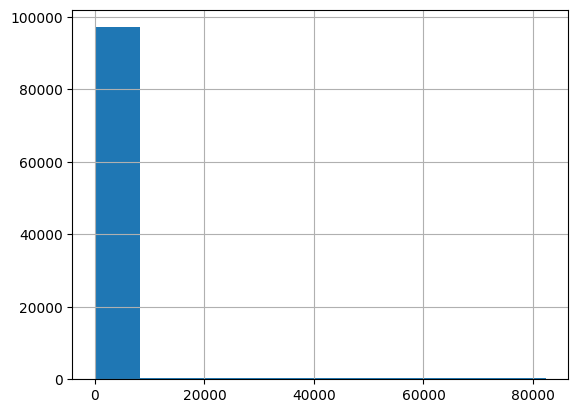

In [ ]:
# df_train['Total_EMI_per_month'].unique()
df_train['Total_EMI_per_month'].hist(bins=10)
#heavy right skew, log transform:
df_train['Total_EMI_per_month'] = np.log(df_train['Total_EMI_per_month'] + 1)
df_train['Total_EMI_per_month'].hist(bins=10)

In [ ]:
print(df_train['Payment_Behaviour'].unique())

#remove odd string: '!@9#%8'
df_train = df_train[~df_train['Payment_Behaviour'].str.contains('!@9#%8',case=False, na=False)]



['High_spent_Small_value_payments' 'Low_spent_Large_value_payments'
 'Low_spent_Medium_value_payments' 'Low_spent_Small_value_payments'
 'High_spent_Medium_value_payments' '!@9#%8'
 'High_spent_Large_value_payments']


In [ ]:
# df_train['Monthly_Balance'].plot.hist()
type(df_train['Monthly_Balance'][0])
df_train['Monthly_Balance'].unique()
df_train['Monthly_Balance'] = pd.to_numeric(df_train['Monthly_Balance'], errors='coerce')


In [ ]:
df_train['Credit_Score'].unique()

array(['Good', 'Standard', 'Poor'], dtype=object)

Nancy: Preprocess following variables:
```
Delay_from_due_date,
Num_of_Delayed_Payment,
Changed_Credit_Limit,
Num_Credit_Inquiries,
Credit_Mix,
Outstanding_Debt,
Credit_Utilization_Ratio,
Payment_Behaviour
```

Delay_from_due_date
 15    3335
 13    3147
 8     3069
 14    3063
 10    3022
       ... 
-4       54
 65      53
 66      32
-5       30
 67      21
Name: count, Length: 73, dtype: int64
max_delay_from_due_date: 67
min_delay_from_due_date: -5


<ipython-input-49-8f699f9813e0>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Delay_from_due_date_clean'] = np.where(df_train['Delay_from_due_date'] <=10, 0, np.where(df_train['Delay_from_due_date'] <=20, 1, np.where(df_train['Delay_from_due_date'] <=30, 2, 3)))


df_train_after_Categortization:
 Delay_from_due_date_clean
1    27280
0    24548
2    22355
3    17673
Name: count, dtype: int64


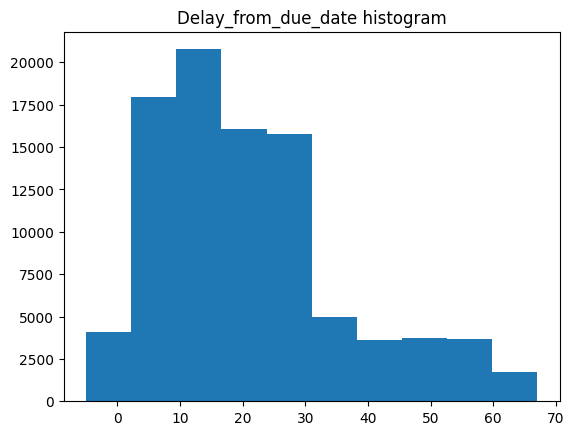

In [ ]:
## Clean up 'Delay_from_due_date' Column
## Focus: Categortize into numeric value evenly

#Checking the value count and range for 'Delay_from_due_date value'
print(df_train.Delay_from_due_date.value_counts())
print('max_delay_from_due_date:',df_train.Delay_from_due_date.max())
print('min_delay_from_due_date:',df_train.Delay_from_due_date.min())

#generate histogam to validate distribution
plt.hist(df_train.Delay_from_due_date, bins=10)
plt.title('Delay_from_due_date histogram')

#From Above Result, having range  (-5 , 67) by defination, need to remove negative value
df_train = df_train[df_train.Delay_from_due_date >= 0]

# Define 4 numeric level base on graph to categortize the variable
#Original value  <10     -> 0
#Original value 10-20     -> 1
#Original value 20-30     -> 2
#Original value > 30     -> 3


df_train['Delay_from_due_date_clean'] = np.where(df_train['Delay_from_due_date'] <=10, 0, np.where(df_train['Delay_from_due_date'] <=20, 1, np.where(df_train['Delay_from_due_date'] <=30, 2, 3)))

#Checking value count after categortization
print('df_train_after_Categortization:\n',df_train.Delay_from_due_date_clean.value_counts())




Num_of_Delayed_Payment
19      5062
17      5000
16      4901
15      4844
18      4835
        ... 
328        1
640        1
2585       1
2230       1
2047       1
Name: count, Length: 661, dtype: int64
max number of delay payment: 4397
min number of delay payment: -3
df_train_after_Categortization:
 Num_of_Delayed_Payment_clean
2    23457
1    22151
3    20621
0    19240
Name: count, dtype: int64


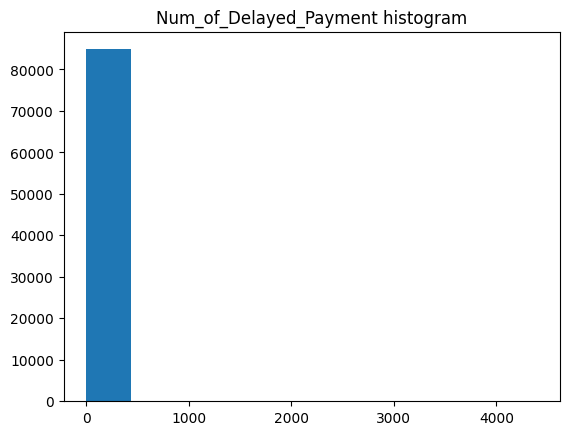

In [ ]:
## Clean up 'Num_of_Delayed_Payment' Column
## Focus: Removing unexpected punctuation characters ,Cast from String Type into Integer Type to fit as input feature.
##        Then Categortize into numeric value evenly

# Cast column as string, drop null value and 'nan' value
df_train['Num_of_Delayed_Payment']=df_train['Num_of_Delayed_Payment'].astype(str)
df_train = df_train.dropna(subset=['Num_of_Delayed_Payment'])
df_train = df_train[df_train['Num_of_Delayed_Payment'] != 'nan']

# Remove unexpected punctuation characters
df_train['Num_of_Delayed_Payment'] = df_train['Num_of_Delayed_Payment'].str.replace('_', '', regex=True)


#Cast Value as Integer Type
df_train['Num_of_Delayed_Payment'] = df_train['Num_of_Delayed_Payment'].astype(int)


#Checking the value count and range for 'Num_of_Delayed_Payment value'
print(df_train.Num_of_Delayed_Payment.value_counts())
print('max number of delay payment:',df_train.Num_of_Delayed_Payment.max())
print('min number of delay payment:',df_train.Num_of_Delayed_Payment.min())

#generate histogam to validate distribution
plt.hist(df_train.Num_of_Delayed_Payment, bins=10)
plt.title('Num_of_Delayed_Payment histogram')

# Define 4 numeric level base on graph to categortize the variable
#Original value  <8     -> 0
#Original value 8-13     -> 1
#Original value 13-18     -> 2
#Original value > 18     -> 3

df_train['Num_of_Delayed_Payment_clean'] = np.where(df_train['Num_of_Delayed_Payment'] <=8, 0, np.where(df_train['Num_of_Delayed_Payment'] <=13, 1, np.where(df_train['Num_of_Delayed_Payment'] <=18, 2, 3)))


#Checking value count after categortization
print('df_train_after_Categortization:\n',df_train.Num_of_Delayed_Payment_clean.value_counts())



Text(0.5, 1.0, 'Changed_Credit_Limit histogram')

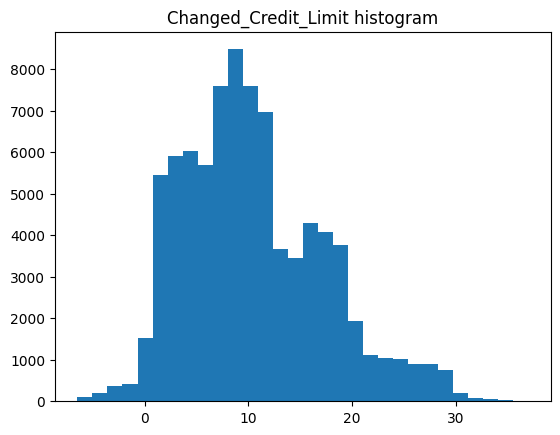

In [ ]:
# Changed_Credit_Limit

## Clean up 'Changed_Credit_Limit' Column
## Focus: Removing unexpected punctuation characters ,Cast from String Type into Integer Type to fit as input feature.

#  drop null value and 'nan' value, Remove unexpected punctuation characters
df_train = df_train[df_train.Changed_Credit_Limit != '']
df_train = df_train[df_train.Changed_Credit_Limit != '_']
df_train = df_train.dropna(subset=['Changed_Credit_Limit'])
df_train['Changed_Credit_Limit'] = df_train['Changed_Credit_Limit'].str.replace('_', '', regex=True)


#Cast Value as Float Type
df_train['Changed_Credit_Limit_clean'] = df_train['Changed_Credit_Limit'].astype(float)

# Plot historgtam to validate distribution
plt.hist(df_train.Changed_Credit_Limit_clean, bins=30)
plt.title('Changed_Credit_Limit histogram')



Text(0.5, 1.0, 'Num_Credit_Inquiries histogram')

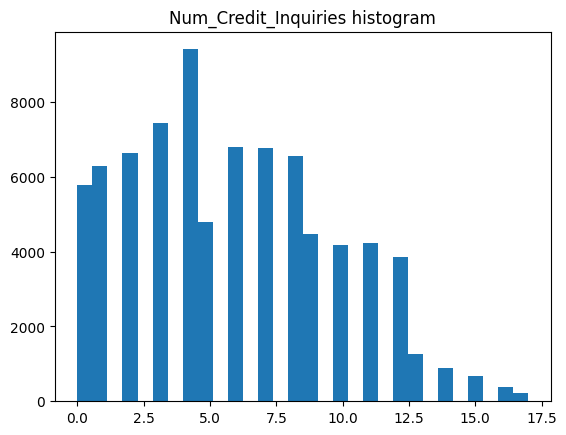

In [ ]:
## Clean up 'Num_Credit_Inquiries' Column
## Focus: Removing Outlierrs

df_train = df_train[df_train.Num_Credit_Inquiries <=20]
plt.hist(df_train.Num_Credit_Inquiries, bins=30)
plt.title('Num_Credit_Inquiries histogram')


In [ ]:
## Clean up 'Credit_Mix' Column
## Focus: Categoritize the value.

##Checking value count

print(df_train.Credit_Mix.value_counts())

#Since we do not know the '_' meaning, we decided to remove this column from the feature list.



Credit_Mix
Standard    29632
Good        19324
_           16338
Bad         15358
Name: count, dtype: int64


Text(0.5, 1.0, 'Outstanding_Debt histogram')

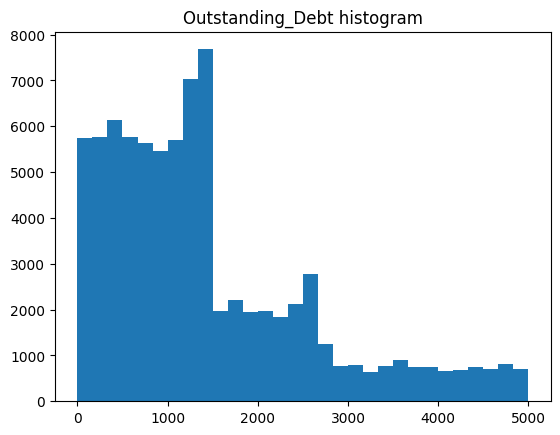

In [ ]:
## Clean up 'Outstanding_Debt' Column
## Focus: Removing unexpected punctuation characters ,Cast from String Type into Integer Type to fit as input feature.

#  drop null value and 'nan' value, Remove unexpected punctuation characters
df_train = df_train[df_train.Outstanding_Debt != '']
df_train = df_train.dropna(subset=['Outstanding_Debt'])
df_train['Outstanding_Debt'] = df_train['Outstanding_Debt'].str.replace('_', '', regex=True)

#Cast Value as Float Type
df_train['Outstanding_Debt_clean'] = df_train['Outstanding_Debt'].astype(float)


# Plot historgtam to validate distribution
plt.hist(df_train.Outstanding_Debt_clean, bins=30)

plt.title('Outstanding_Debt histogram')

Text(0.5, 1.0, 'Credit_Utilization_Ratio histogram')

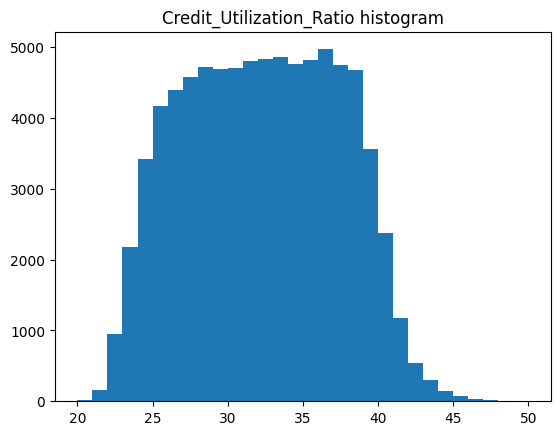

In [ ]:
## Clean up 'Credit_Utilization_Ratio' Column

plt.hist(df_train.Credit_Utilization_Ratio, bins=30)

plt.title('Credit_Utilization_Ratio histogram')
#Feature is continuous and donot need extra cleanning.

In [ ]:
## Clean up 'Payment_Behaviour' Column
## Focus: Removing unexpected punctuation characters ,Then Categortize into numeric value evenly

#  drop null value and 'nan' value, Remove unexpected punctuation characters

df_train[df_train['Payment_Behaviour']!= '!@9#%8']
print(df_train['Payment_Behaviour'].value_counts())

#Categortize the variable
#Original Value :'High_spent_Small_value_payments'     -> 0
#Original Value :'Low_spent_Large_value_payments'     -> 1
#Original Value :'Low_spent_Medium_value_payments     -> 2
#Original Value :'High_spent_Medium_value_payments'     -> 3
#Original Value :'High_spent_Large_value_payments'     -> 4


df_train['Payment_Behaviour_clean'] = np.where(df_train['Payment_Behaviour'] =="High_spent_Small_value_payments", 0,\
                                               np.where(df_train['Payment_Behaviour'] =='Low_spent_Large_value_payments', 1,\
                                                        np.where(df_train['Payment_Behaviour'] =='Low_spent_Medium_value_payments', 2,\
                                                                 np.where(df_train['Payment_Behaviour'] =='High_spent_Medium_value_payments', 3,4))))
#Checking value count after categortization
print('Train df Payment_Behaviour_clean:\n',df_train['Payment_Behaviour_clean'].value_counts())



Payment_Behaviour
Low_spent_Small_value_payments      22234
High_spent_Medium_value_payments    15321
Low_spent_Medium_value_payments     12074
High_spent_Large_value_payments     12009
High_spent_Small_value_payments      9914
Low_spent_Large_value_payments       9100
Name: count, dtype: int64
Train df Payment_Behaviour_clean:
 Payment_Behaviour_clean
4    34243
3    15321
2    12074
0     9914
1     9100
Name: count, dtype: int64


In [ ]:
## Clean up 'Credit_Score' Column
## Focus: Removing unexpected punctuation characters ,Then Categortize into numeric value evenly

#
print(df_train['Credit_Score'].value_counts())
#Categortize the variable
#Original Value :'Good'     -> 0
#Original Value :'Standard'     -> 1
#Original Value :'Poor'    -> 2

df_train['Credit_Score_clean'] = np.where(df_train['Credit_Score'] =="Good", 0, np.where(df_train['Credit_Score'] =="Standard", 1, 2))

#Checking value count after categortization
print('Train df Credit_Score:\n',df_train['Credit_Score_clean'].value_counts())

Credit_Score
Standard    42963
Poor        23503
Good        14186
Name: count, dtype: int64
Train df Credit_Score:
 Credit_Score_clean
1    42963
2    23503
0    14186
Name: count, dtype: int64


## Step 5: Retain potential columns for use in training and testing sets ##

In [ ]:
# select all columns with potential as features
# (relatively low number of null or malformed values)
df_cred_score = df_train[[
    'Annual_Income',
    'Num_Bank_Accounts',
    'Num_Credit_Card',
    'Interest_Rate',
    'Num_of_Loan',
    'Delay_from_due_date_clean',
    'Num_of_Delayed_Payment_clean',
    'Changed_Credit_Limit_clean',
    'Num_Credit_Inquiries',
    'Outstanding_Debt_clean',
    'Credit_Utilization_Ratio',
    'Credit_History_Age',
    'Total_EMI_per_month',
     'Payment_Behaviour_clean',
    'Monthly_Balance',
    'Credit_Score_encoded'
    ]]


## Step 6: Drop rows with null values after preprocessing all needed columns ##

In [ ]:
# drop NA rows after column retention
df_cred_score = df_cred_score.dropna()

## Step 7: (EDA 2) Examine preprocessed dataset ##

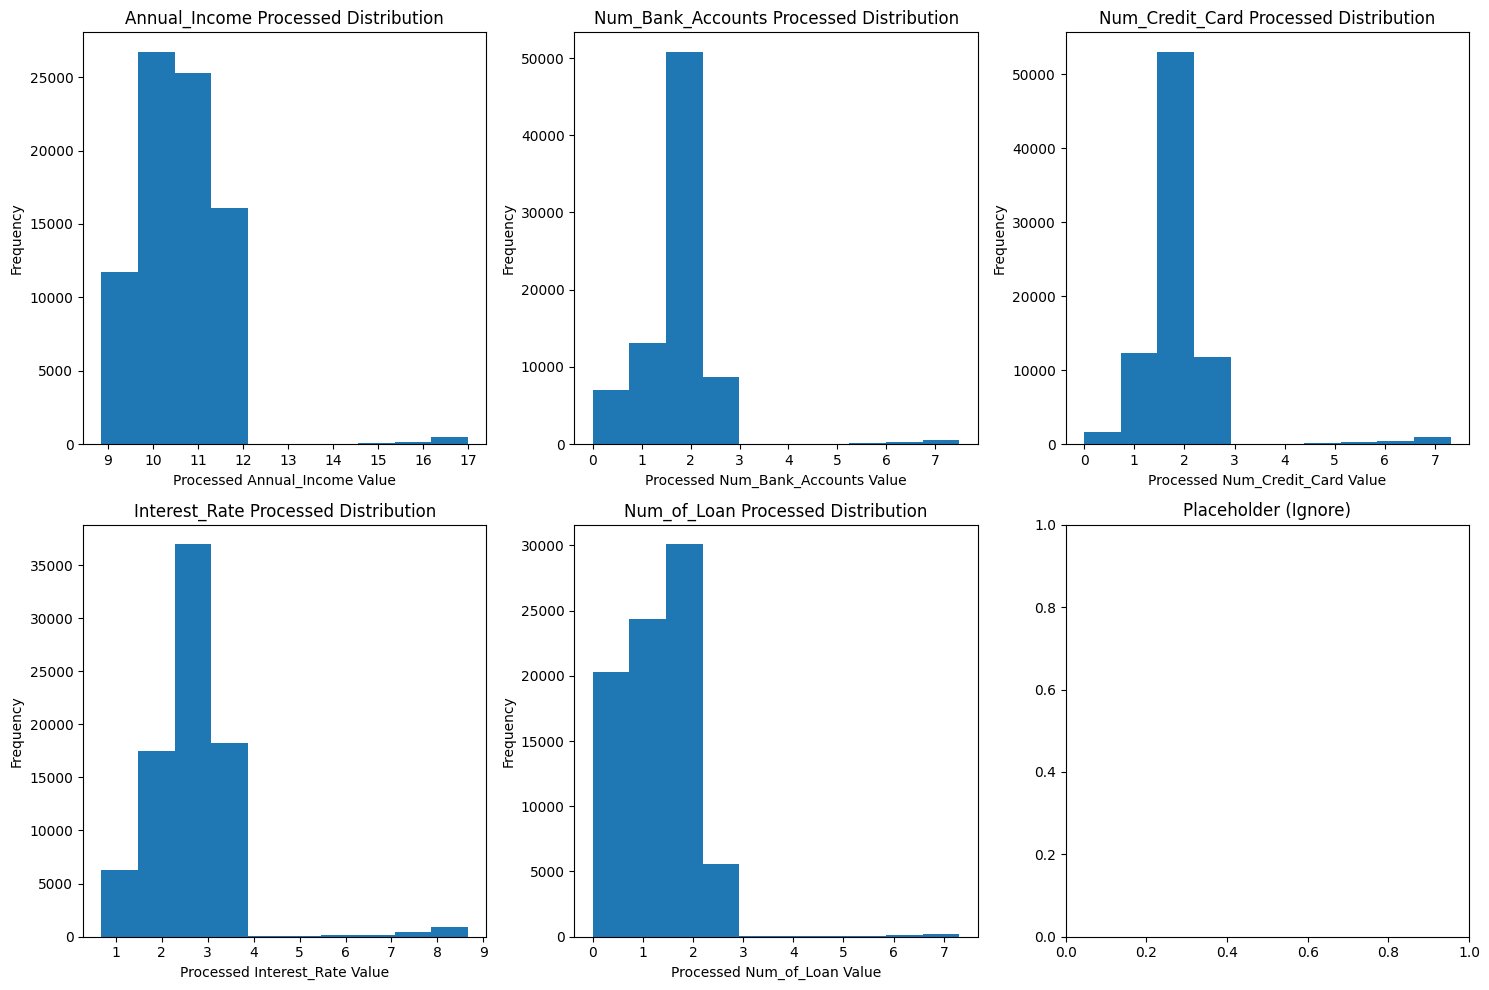

In [ ]:
# put histograms and any other EDA plots here
column_set_list = [
    "Annual_Income",
    "Num_Bank_Accounts",
    "Num_Credit_Card",
    "Interest_Rate",
    "Num_of_Loan"
]
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
col_index = 0
for i in range(2):
    for j in range(3):
        if (i + 1) * (j + 1) >= len(column_set_list):
            ax[i, j].set_title(f'Placeholder (Ignore)')
            break
        ax[i, j].hist(df_train[column_set_list[col_index]], bins=10)
        ax[i, j].set_title(f'{column_set_list[col_index]} Processed Distribution')
        ax[i, j].set_ylabel('Frequency')
        ax[i, j].set_xlabel(f'Processed {column_set_list[col_index]} Value')
        col_index += 1

plt.tight_layout()
plt.show()

In [ ]:
print(f'Processed training data shape: {df_train.shape}')

print(f'Processed training data types: \n{df_train.dtypes}')

Processed training data shape: (80652, 36)
Processed training data types: 
ID                                object
Customer_ID                       object
Month                             object
Name                              object
Age                              float64
SSN                               object
Occupation                        object
Annual_Income                    float64
Monthly_Inhand_Salary            float32
Num_Bank_Accounts                float64
Num_Credit_Card                  float32
Interest_Rate                    float32
Num_of_Loan                      float64
Type_of_Loan                      object
Delay_from_due_date                int64
Num_of_Delayed_Payment             int64
Changed_Credit_Limit              object
Num_Credit_Inquiries             float64
Credit_Mix                        object
Outstanding_Debt                  object
Credit_Utilization_Ratio         float64
Credit_History_Age               float64
Payment_of_Min_Amount  

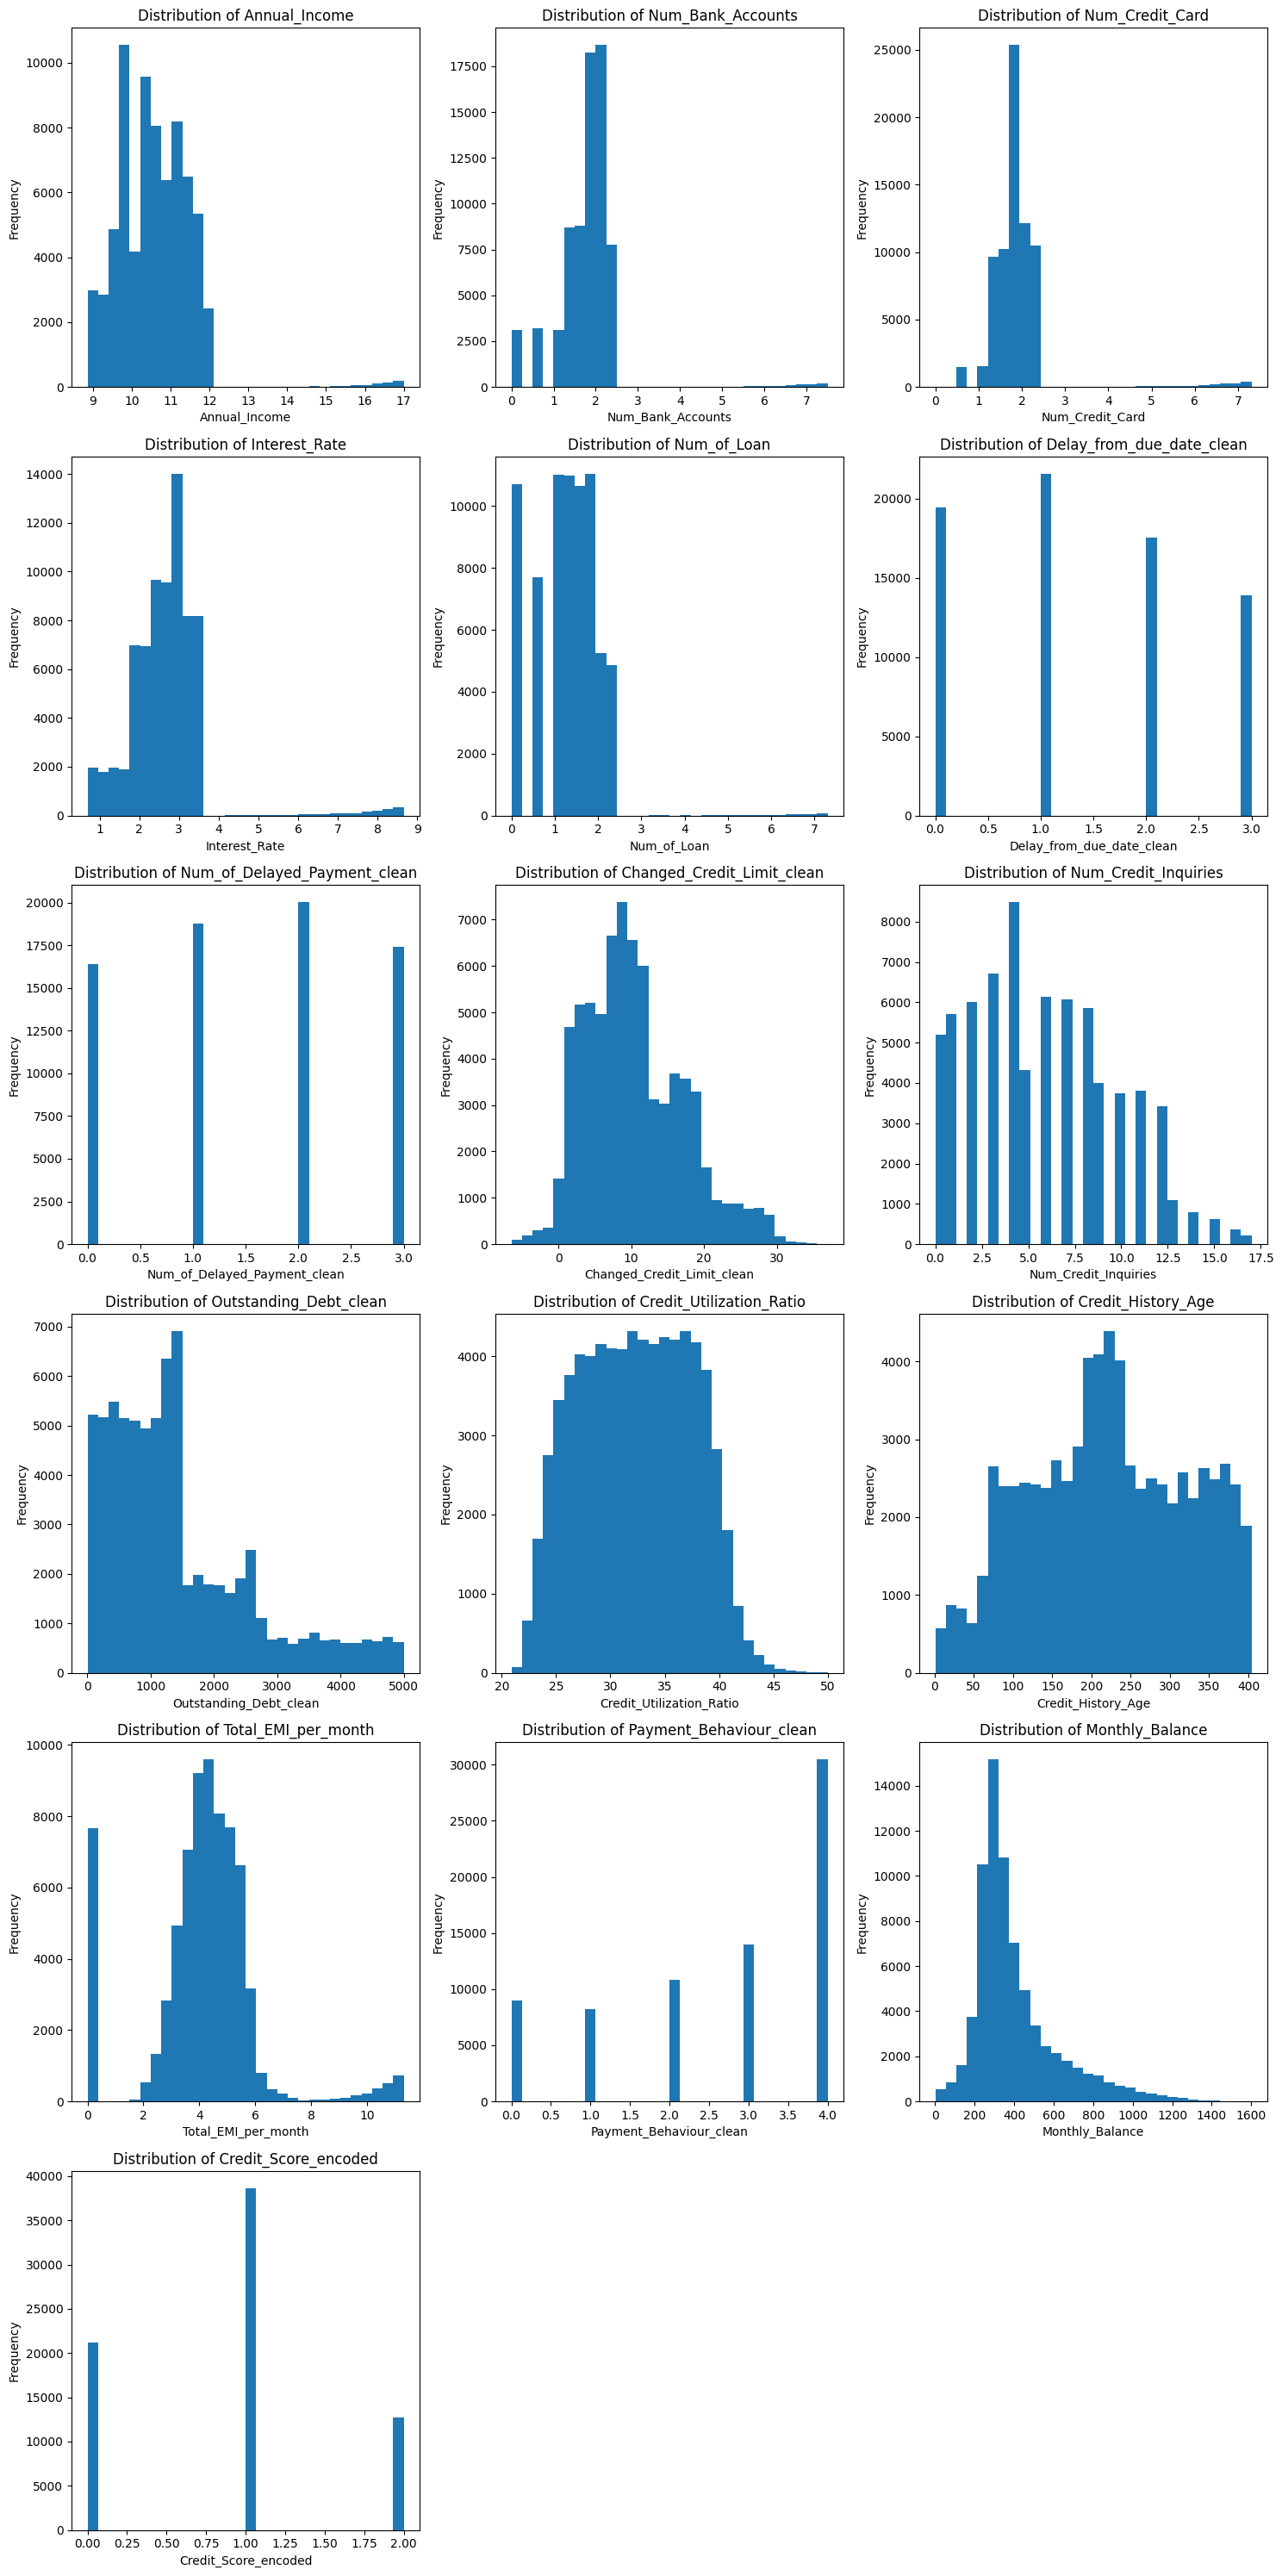

In [ ]:
# Calculate number of rows needed for subplot grid
n_features = len(df_cred_score.columns)
n_rows = (n_features + 2) // 3  # 3 columns per row, rounded up

# Create subplot grid
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Create histograms for each feature
for i, col in enumerate(df_cred_score.columns):
    axes[i].hist(df_cred_score[col], bins=30)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [ ]:
# Count unique values for each column
unique_counts = df_cred_score.nunique()

# Get features with less than 6 unique values
discrete_features = list(unique_counts[unique_counts < 10].index)

# Remove Credit_Score from discrete_features if it's there
discrete_features = [x for x in discrete_features if x != 'Credit_Score_encoded']

# Print results
print("Features with less than 10 unique values:")
print("\nDiscrete features:", discrete_features)
print("\nNumber of unique values in each discrete feature:")
for feature in discrete_features:
    print(f"{feature}: {df_cred_score[feature].nunique()} unique values")
    print("Values:", sorted(df_cred_score[feature].unique()))

Features with less than 10 unique values:

Discrete features: ['Delay_from_due_date_clean', 'Num_of_Delayed_Payment_clean', 'Payment_Behaviour_clean']

Number of unique values in each discrete feature:
Delay_from_due_date_clean: 4 unique values
Values: [0, 1, 2, 3]
Num_of_Delayed_Payment_clean: 4 unique values
Values: [0, 1, 2, 3]
Payment_Behaviour_clean: 5 unique values
Values: [0, 1, 2, 3, 4]


In [ ]:
# Get continuous features by excluding discrete features
continuous_features = [col for col in df_cred_score.columns if col not in discrete_features]

print("Continuous features:")
print(continuous_features)

# Get continuous features by excluding discrete features and Credit_Score
continuous_features = [col for col in continuous_features if col != 'Credit_Score_encoded']
print("Continuous features after removing Credit_Score:")
print(continuous_features)

Continuous features:
['Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Changed_Credit_Limit_clean', 'Num_Credit_Inquiries', 'Outstanding_Debt_clean', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Monthly_Balance', 'Credit_Score_encoded']
Continuous features after removing Credit_Score:
['Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Changed_Credit_Limit_clean', 'Num_Credit_Inquiries', 'Outstanding_Debt_clean', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Monthly_Balance']


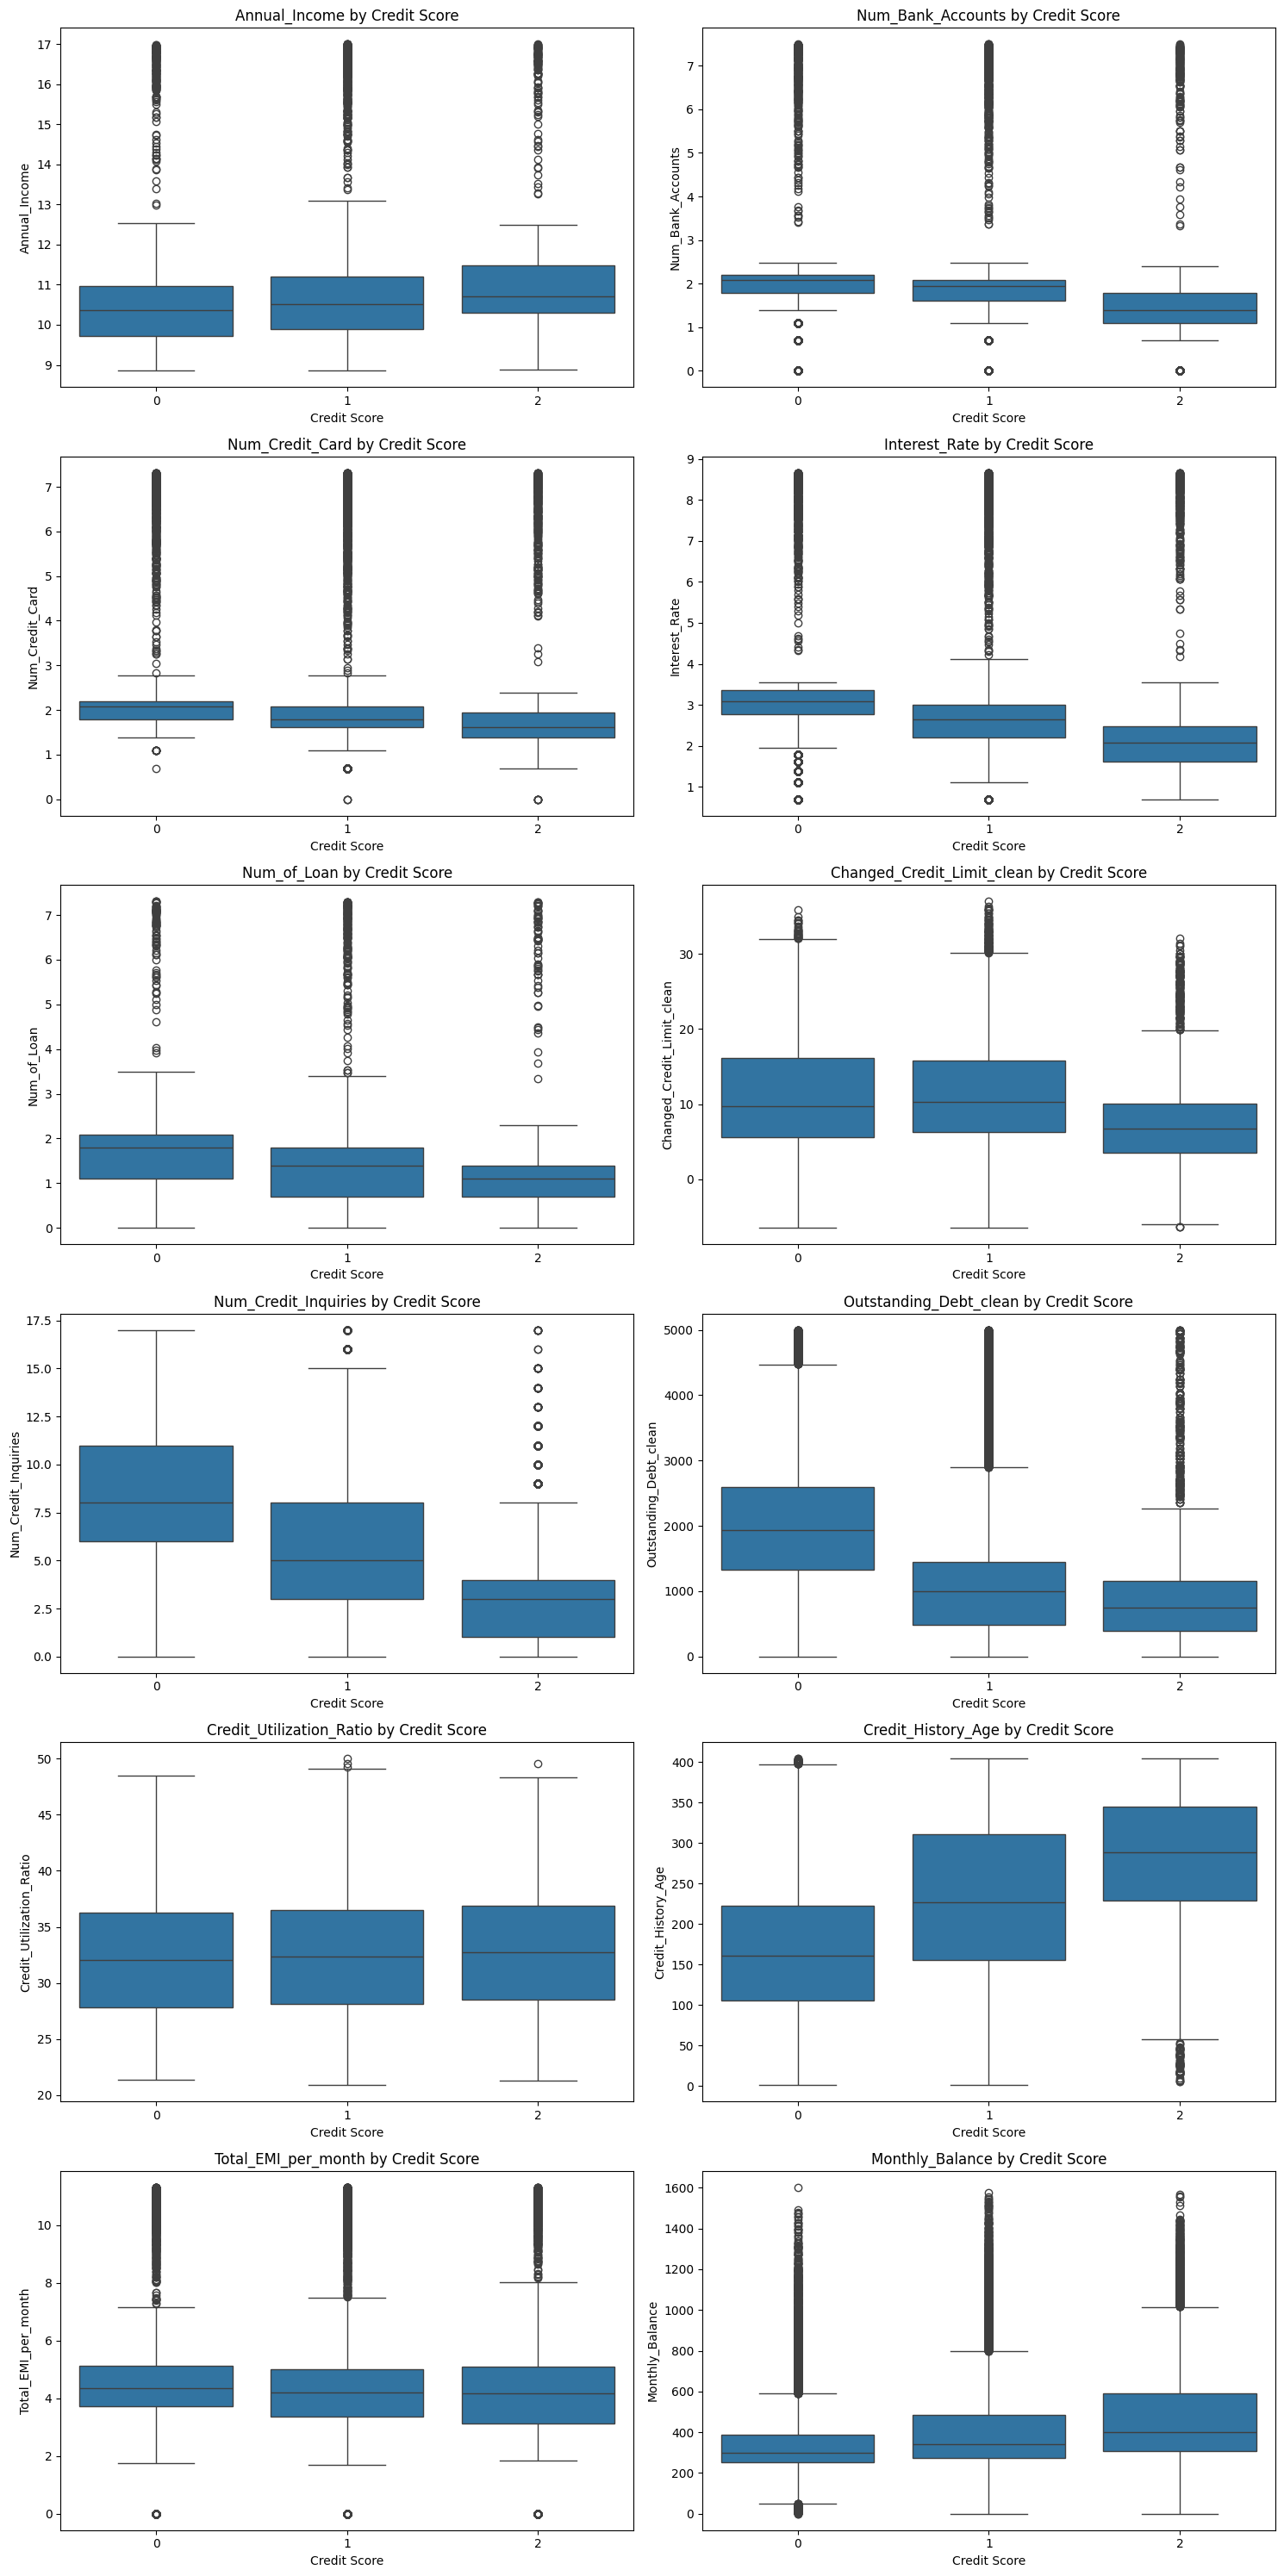

In [ ]:
# Calculate number of rows needed for subplot grid
n_features = len(continuous_features)
n_rows = (n_features + 1) // 2  # 2 columns per row, rounded up

# Create subplot grid
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Create boxplots for each continuous feature
for i, feature in enumerate(continuous_features):
    sns.boxplot(x='Credit_Score_encoded', y=feature, data=df_cred_score, ax=axes[i])
    axes[i].set_title(f'{feature} by Credit Score')
    axes[i].set_xlabel('Credit Score')
    axes[i].set_ylabel(feature)

# Remove any empty subplots
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


Chi-square test for Delay_from_due_date_clean:
Chi-square statistic: 14839.94
p-value: 0.0000000000

Chi-square test for Num_of_Delayed_Payment_clean:
Chi-square statistic: 10884.80
p-value: 0.0000000000

Chi-square test for Payment_Behaviour_clean:
Chi-square statistic: 214.48
p-value: 0.0000000000


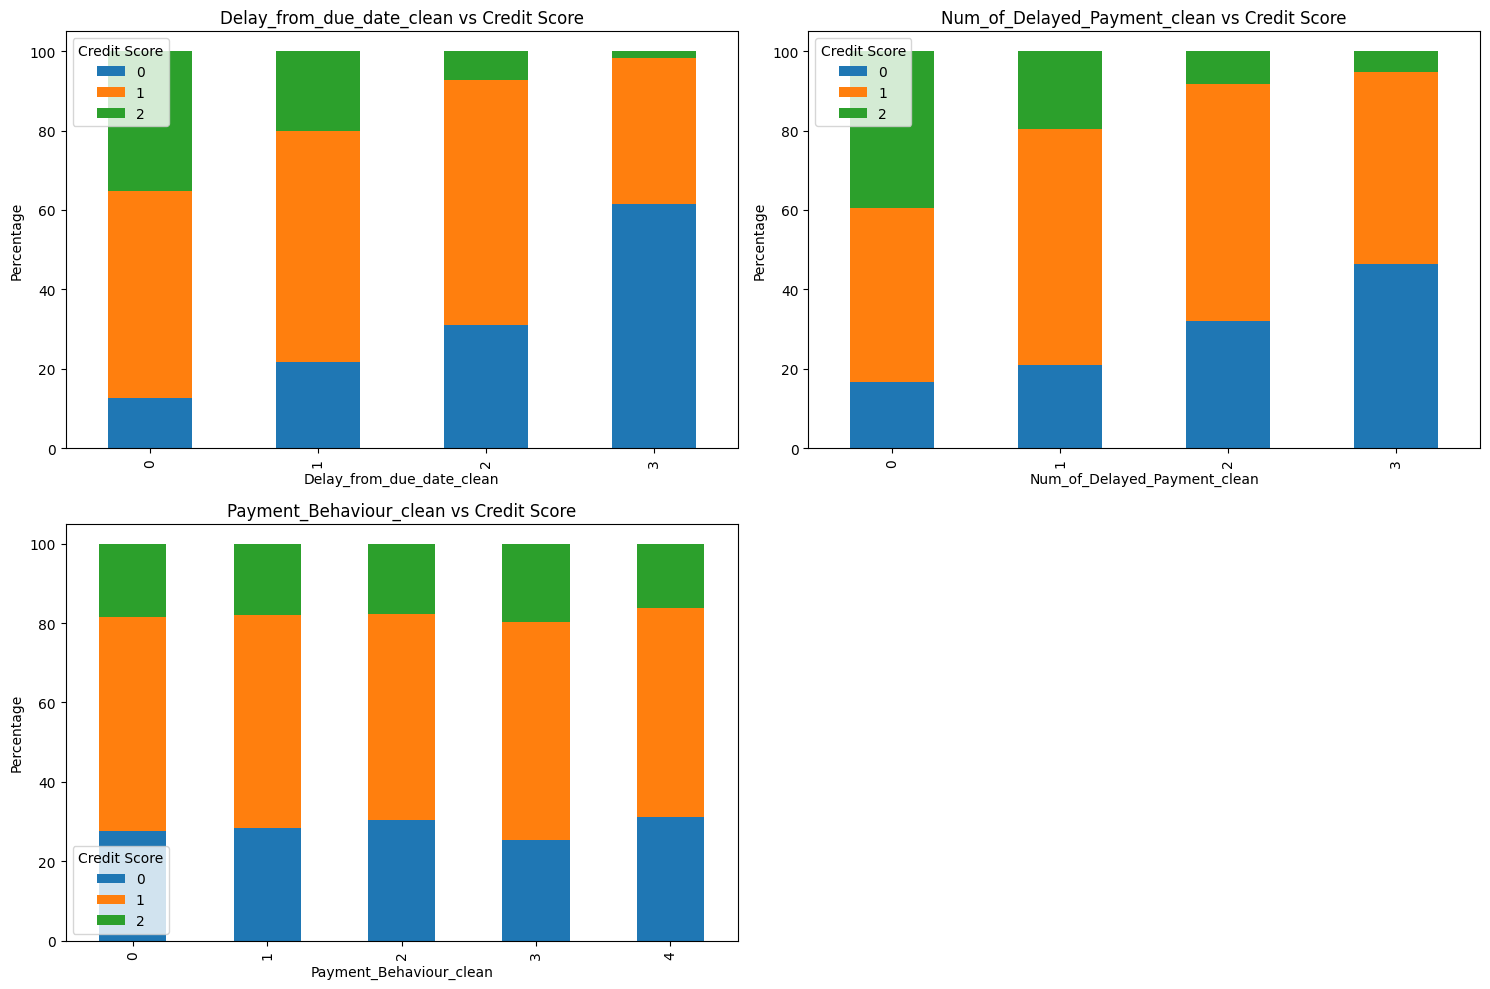


Counts for Delay_from_due_date_clean:
Credit_Score_encoded          0      1     2
Delay_from_due_date_clean                   
0                          2484  10127  6865
1                          4673  12562  4358
2                          5458  10845  1272
3                          8541   5123   245

Percentages for Delay_from_due_date_clean:
Credit_Score_encoded          0     1     2
Delay_from_due_date_clean                  
0                          12.8  52.0  35.2
1                          21.6  58.2  20.2
2                          31.1  61.7   7.2
3                          61.4  36.8   1.8

Counts for Num_of_Delayed_Payment_clean:
Credit_Score_encoded             0      1     2
Num_of_Delayed_Payment_clean                   
0                             2750   7153  6496
1                             3910  11170  3672
2                             6411  11928  1678
3                             8085   8406   894

Percentages for Num_of_Delayed_Payment_clean:
Credit

In [ ]:
# Calculate number of rows needed for subplot grid
n_features = len(discrete_features)
n_rows = (n_features + 1) // 2  # 2 columns per row, rounded up

# Create subplot grid
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Create stacked bar plots and perform chi-square tests for each discrete feature
for i, feature in enumerate(discrete_features):
    # Create crosstab
    ct = pd.crosstab(df_cred_score[feature], df_cred_score['Credit_Score_encoded'], normalize='index') * 100

    # Create stacked bar plot
    ct.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'{feature} vs Credit Score')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Percentage')
    axes[i].legend(title='Credit Score')

    # Perform chi-square test
    contingency_table = pd.crosstab(df_cred_score[feature], df_cred_score['Credit_Score_encoded'])
    chi2, p_value = chi2_contingency(contingency_table)[:2]
    print(f'\nChi-square test for {feature}:')
    print(f'Chi-square statistic: {chi2:.2f}')
    print(f'p-value: {p_value:.10f}')

# Remove any empty subplots
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Print the actual counts and percentages for each feature
for feature in discrete_features:
    print(f'\nCounts for {feature}:')
    print(pd.crosstab(df_cred_score[feature], df_cred_score['Credit_Score_encoded']))
    print(f'\nPercentages for {feature}:')
    print(pd.crosstab(df_cred_score[feature], df_cred_score['Credit_Score_encoded'], normalize='index').round(3) * 100)

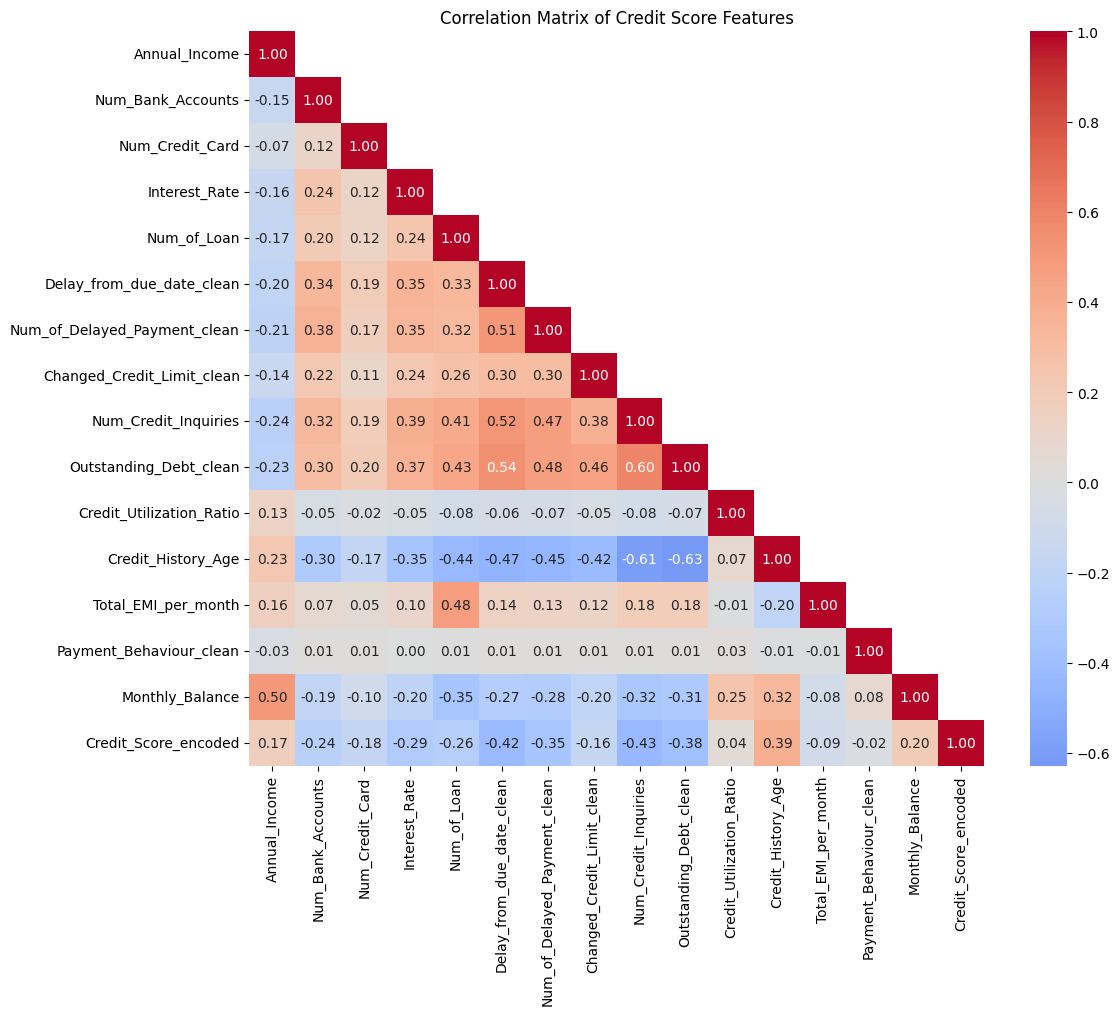


Correlations with Credit_Score (sorted by absolute value):
Num_Credit_Inquiries           -0.432293
Delay_from_due_date_clean      -0.422707
Credit_History_Age              0.385709
Outstanding_Debt_clean         -0.383071
Num_of_Delayed_Payment_clean   -0.346681
Interest_Rate                  -0.294883
Num_of_Loan                    -0.261168
Num_Bank_Accounts              -0.241996
Monthly_Balance                 0.202959
Num_Credit_Card                -0.175951
Annual_Income                   0.173105
Changed_Credit_Limit_clean     -0.164793
Total_EMI_per_month            -0.090714
Credit_Utilization_Ratio        0.044897
Payment_Behaviour_clean        -0.024763
Name: Credit_Score_encoded, dtype: float64


In [ ]:
# Calculate correlation matrix
correlation_matrix = df_cred_score.corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            fmt='.2f',  # Round to 2 decimal places
            square=True,  # Make cells square
            mask=np.triu(correlation_matrix, k=1))  # Show only lower triangle

plt.title('Correlation Matrix of Credit Score Features')
plt.tight_layout()
plt.show()

# Print the correlation values with Credit_Score
print("\nCorrelations with Credit_Score (sorted by absolute value):")
credit_score_corr = correlation_matrix['Credit_Score_encoded'].drop('Credit_Score_encoded')
credit_score_corr_sorted = credit_score_corr.reindex(credit_score_corr.abs().sort_values(ascending=False).index)
print(credit_score_corr_sorted)

## Step 8: Shuffle and split data into training, validation, and test

In [ ]:
# this code block for credit score predictions
# split data into features and labels
y_col_name = 'Credit_Score_encoded'

Y = df_cred_score[y_col_name]
X = df_cred_score.drop(columns=[y_col_name])

# shuffle datasets using indexing
index_shuffled = np.random.permutation(len(X))
X = X.iloc[index_shuffled]
Y = Y.iloc[index_shuffled]


# TODO: split training data into training + validation + testing sets (0.6, 0.2, 0.2)
X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size=0.25)

In [ ]:
# verify shapes of datasets
print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'Y_val shape: {Y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_test shape: {Y_test.shape}')
# verify datatypes of datasets
print(f'X_train dtypes: \n{X_train.dtypes}')
print(f'Y_train dtypes: \n{Y_train.dtypes}')
print(f'X_val dtypes: \n{X_val.dtypes}')
print(f'Y_val dtypes: \n{Y_val.dtypes}')
print(f'X_test dtypes: \n{X_test.dtypes}')
print(f'Y_test dtypes: \n{Y_test.dtypes}')
# verify no null rows
X_train[X_train.isnull().any(axis=1)]
X_val[X_val.isnull().any(axis=1)]
X_test[X_test.isnull().any(axis=1)]

X_train shape: (43531, 15)
Y_train shape: (43531,)
X_val shape: (14511, 15)
Y_val shape: (14511,)
X_test shape: (14511, 15)
Y_test shape: (14511,)
X_train dtypes: 
Annual_Income                   float64
Num_Bank_Accounts               float64
Num_Credit_Card                 float32
Interest_Rate                   float32
Num_of_Loan                     float64
Delay_from_due_date_clean         int64
Num_of_Delayed_Payment_clean      int64
Changed_Credit_Limit_clean      float64
Num_Credit_Inquiries            float64
Outstanding_Debt_clean          float64
Credit_Utilization_Ratio        float64
Credit_History_Age              float64
Total_EMI_per_month             float64
Payment_Behaviour_clean           int64
Monthly_Balance                 float64
dtype: object
Y_train dtypes: 
int64
X_val dtypes: 
Annual_Income                   float64
Num_Bank_Accounts               float64
Num_Credit_Card                 float32
Interest_Rate                   float32
Num_of_Loan             

,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date_clean,Num_of_Delayed_Payment_clean,Changed_Credit_Limit_clean,Num_Credit_Inquiries,Outstanding_Debt_clean,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Payment_Behaviour_clean,Monthly_Balance


## Step 9: Normalize features ##

In [ ]:
# TODO: normalize quantitative variables to 0.0 to 1.0 scale (or -1.0 to 1.0)
# function that normalizes given single column to 0.0-1.0 scale
def normalize_column(original_col):
    min_val = original_col.min()
    max_val = original_col.max()
    return (original_col - min_val) / (max_val - min_val)


for col in X_train.columns:
    X_train[col] = normalize_column(X_train[col])

for col in X_val.columns:
    X_val[col] = normalize_column(X_val[col])

for col in X_test.columns:
    X_test[col] = normalize_column(X_test[col])

X_train

,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date_clean,Num_of_Delayed_Payment_clean,Changed_Credit_Limit_clean,Num_Credit_Inquiries,Outstanding_Debt_clean,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Payment_Behaviour_clean,Monthly_Balance
37220,0.278691,0.293159,0.189560,0.252864,0.220457,0.666667,0.666667,0.205896,0.176471,0.295160,0.194347,0.803483,0.458026,0.50,0.128306
34689,0.224226,0.000000,0.189560,0.201980,0.150485,0.000000,0.333333,0.172906,0.000000,0.075220,0.278141,0.562189,0.353631,0.50,0.227589
44568,0.358337,0.293159,0.266081,0.295090,0.094946,0.000000,0.000000,0.408283,0.000000,0.071755,0.830277,0.706468,0.959251,0.75,0.648988
85043,0.179626,0.259628,0.245003,0.173976,0.189891,0.333333,1.000000,0.359148,0.000000,0.167636,0.242377,0.462687,0.506230,1.00,0.267657
98715,0.184875,0.259628,0.284340,0.282530,0.150485,1.000000,1.000000,0.321245,0.352941,0.155803,0.339496,0.589552,0.332010,0.25,0.215543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2831,0.197193,0.259628,0.220072,0.114992,0.000000,0.333333,1.000000,0.416706,0.352941,0.231764,0.627431,0.791045,0.000000,0.75,0.286979
31972,0.270346,0.259628,0.189560,0.188757,0.189891,0.666667,0.666667,0.491109,0.058824,0.109813,0.390903,0.917910,0.444152,0.75,0.278304
43569,0.193084,0.277444,0.284340,0.252864,0.150485,0.666667,0.666667,0.232569,0.000000,0.123866,0.503377,0.703980,0.312963,0.00,0.238709
41143,0.270522,0.239061,0.284340,0.295090,0.245431,0.666667,0.666667,0.547029,0.647059,0.205905,0.271803,0.420398,0.450780,0.50,0.132597


## Step 10: Set up and evaluate baseline prediction model ##

In [ ]:
# Baseline model: Majority Classifier
baseline = 1

# calculate performance of baseline classifier
baseline_pred = np.ones(Y_test.shape)
score = classification_report(Y_test, baseline_pred)
# baseline_accuracy = Y_test[Y_test == 1].sum()/len(Y_test) # weighted f1 score ben TODO
print(f'Baseline Majority Classifier Performance: \n {score}')

Baseline Majority Classifier Performance: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      4249
           1       0.53      1.00      0.69      7710
           2       0.00      0.00      0.00      2552

    accuracy                           0.53     14511
   macro avg       0.18      0.33      0.23     14511
weighted avg       0.28      0.53      0.37     14511



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Step 11: Select most useful features for training models ##

In [ ]:
from sklearn.feature_selection import mutual_info_classif
for column in X_train.columns:
    mi_score = mutual_info_classif(X_train[[column]], Y_train)
    print(f'Mutual info score for {column}: {mi_score}')

Mutual info score for Annual_Income: [0.418241]
Mutual info score for Num_Bank_Accounts: [0.10368224]
Mutual info score for Num_Credit_Card: [0.10128678]
Mutual info score for Interest_Rate: [0.16463615]
Mutual info score for Num_of_Loan: [0.07556683]
Mutual info score for Delay_from_due_date_clean: [0.10608815]
Mutual info score for Num_of_Delayed_Payment_clean: [0.07400917]
Mutual info score for Changed_Credit_Limit_clean: [0.09275821]
Mutual info score for Num_Credit_Inquiries: [0.11364892]
Mutual info score for Outstanding_Debt_clean: [0.45238506]
Mutual info score for Credit_Utilization_Ratio: [0]
Mutual info score for Credit_History_Age: [0.10273314]
Mutual info score for Total_EMI_per_month: [0.34595809]
Mutual info score for Payment_Behaviour_clean: [0.00546343]
Mutual info score for Monthly_Balance: [0.03243474]


Most useful features seem to be:

* Outstanding_Debt_clean
* Annual_Income
* Total_EMI_per_month
* Interest_Rate
* Num_Credit_Inquiries
* Delay_from_due_date_clean
* Num_Credit_Card
* Num_Bank_Accounts
* Credit_History_Age
* Changed_Credit_Limit_clean
* Num_of_Loan
* Num_of_Delayed_Payment_clean

In [ ]:
# select final features for models
X_train_features = X_train[[
    "Outstanding_Debt_clean",
    "Annual_Income",
    "Total_EMI_per_month",
    "Interest_Rate",
    "Num_Credit_Inquiries",
    "Delay_from_due_date_clean",
    "Num_Credit_Card",
    "Num_Bank_Accounts",
    "Credit_History_Age",
    "Changed_Credit_Limit_clean",
    "Num_of_Loan",
    "Num_of_Delayed_Payment_clean"
]]

X_val_features = X_val[[
    "Outstanding_Debt_clean",
    "Annual_Income",
    "Total_EMI_per_month",
    "Interest_Rate",
    "Num_Credit_Inquiries",
    "Delay_from_due_date_clean",
    "Num_Credit_Card",
    "Num_Bank_Accounts",
    "Credit_History_Age",
    "Changed_Credit_Limit_clean",
    "Num_of_Loan",
    "Num_of_Delayed_Payment_clean"
]]

X_test_features = X_test[[
    "Outstanding_Debt_clean",
    "Annual_Income",
    "Total_EMI_per_month",
    "Interest_Rate",
    "Num_Credit_Inquiries",
    "Delay_from_due_date_clean",
    "Num_Credit_Card",
    "Num_Bank_Accounts",
    "Credit_History_Age",
    "Changed_Credit_Limit_clean",
    "Num_of_Loan",
    "Num_of_Delayed_Payment_clean"
]]

## Step 12: Set up & train main prediction models ##

### RandomForest Ensemble Classifier Model

#### Manual RandomForest Tests (Subset of all tests performed):

|Max Tree Depth|Max Features|Num Estimators|Bootstrap Data?|Class Weight|Weighted F1 Score|
|-|-|-|-|-|-|
|None|sqrt|50|True|None|0.77125|
|None|sqrt|75|True|None|0.77409|
|None|sqrt|100|True|None|0.77404|
|None|sqrt|150|True|None|0.77340|
|None|sqrt|200|True|None|0.78155|
|None|sqrt|250|True|None|0.77232|
|None|0.2|200|True|None|0.77461|
|None|0.5|100|True|None|0.77233|
|None|0.5|200|True|None|0.77400|
|None|0.8|200|True|None|0.77291|
|None|sqrt|200|False|None|0.77362|
|None|0.2|200|False|None|0.77332|
|None|sqrt|200|True|Balanced|0.77142|
|None|sqrt|200|False|Balanced|0.77091|
|30|sqrt|200|False|None|0.77373|
|40|sqrt|200|False|None|0.77396|
|50|sqrt|200|False|None|0.77334|
|60|sqrt|200|False|None|0.77317|

In [ ]:
# randomforest ensemble classifier
clf = RandomForestClassifier(max_depth=None, max_features='sqrt', n_estimators=200, bootstrap=True, class_weight=None)

# Fit the model on the training data
clf.fit(X_train_features, Y_train)

RandomForestClassifier(n_estimators=200)

In [ ]:
# Access the maximum depth of each tree
max_depths = [estimator.tree_.max_depth for estimator in clf.estimators_]
print("Maximum depths of all trees:", max_depths)
print("Overall maximum depth:", max(max_depths))

Maximum depths of all trees: [43, 36, 43, 35, 38, 36, 43, 41, 37, 34, 42, 44, 49, 40, 40, 35, 41, 41, 37, 42, 39, 37, 36, 41, 36, 44, 38, 35, 40, 40, 36, 40, 35, 38, 36, 38, 45, 39, 44, 39, 36, 40, 36, 40, 49, 36, 40, 36, 44, 38, 46, 38, 41, 41, 43, 50, 34, 38, 37, 37, 38, 41, 37, 39, 41, 45, 38, 40, 41, 39, 38, 37, 40, 36, 41, 37, 41, 38, 43, 37, 45, 41, 37, 38, 45, 43, 37, 38, 44, 37, 38, 39, 41, 39, 39, 38, 37, 44, 37, 35, 40, 34, 39, 36, 45, 39, 41, 39, 39, 36, 37, 41, 38, 43, 44, 44, 38, 36, 43, 40, 37, 45, 41, 37, 37, 37, 40, 35, 38, 37, 34, 37, 38, 34, 39, 40, 35, 38, 42, 39, 38, 36, 33, 37, 40, 36, 38, 43, 49, 38, 38, 41, 36, 40, 40, 43, 41, 49, 38, 36, 40, 38, 37, 34, 39, 38, 36, 36, 35, 33, 39, 38, 38, 41, 45, 39, 39, 39, 38, 35, 38, 41, 39, 38, 43, 37, 37, 39, 42, 37, 38, 37, 35, 35, 37, 36, 36, 37, 38, 47]
Overall maximum depth: 50


In [ ]:
# view all hyperparameters of randomforest model
params = clf.get_params()

print("RandomForest Model Hyperparameters:")
for key, value in params.items():
    print(f"{key}: {value}")

RandomForest Model Hyperparameters:
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 200
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


### Neural Network Model

#### Manual NN Tests (subset of all tests performed):

|Learning Rate|Num of Hidden Layers| Hidden Layer Size|Activation Function|Num of Epochs|Weighted F1 Score|
|-|-|-|-|-|-|
|0.001|0|n/a|Relu|50|0.56344|
|0.001|0|n/a|Relu|100|0.58593|
|0.001|0|n/a|Relu|150|0.59797|
|0.01|0|n/a|Relu|50|0.60126|
|0.01|0|n/a|Relu|100|0.60472|
|0.01|0|n/a|Relu|150|0.61107|
|0.01|1|3|Relu|150|0.62008|
|0.01|1|6|Relu|150|0.61454|
|0.01|2|6|Relu|150|0.63898|
|0.01|3|6|Relu|150|0.37136|
|0.01|1|6|Tanh|150|0.65217|
|0.01|2|6|Tanh|150|0.64768|
|0.01|3|6|Tanh|150|0.37318|
|0.01|1|10|Relu|150|0.65364|
|0.01|1|15|Relu|150|0.65241|
|0.01|1|20|Relu|150|0.65700|
|0.01|1|20|Relu|200|0.65534|
|0.01|1|20|Tanh|200|0.65136|

#### Best manually tested NN model:

In [ ]:
# function to build model (tuned from trial runs)
def build_model(num_features, learning_rate):
    """Build a TF linear regression model using Keras.

    Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """
    # This is not strictly necessary, but each time you build a model, TF adds
    # new nodes (rather than overwriting), so the colab session can end up
    # storing lots of copies of the graph when you only care about the most
    # recent.
    tf.keras.backend.clear_session()

    # Build a model using keras.Sequential.
    model = tf.keras.Sequential()

    # create input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'))

    # create hidden layer
    model.add(tf.keras.layers.Dense(
        units=20,        # number of hidden units, best is 20 so far
        use_bias=True,               # use a bias
        activation='relu',
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        name='Hidden1'
    ))

    # create output layer
    model.add(tf.keras.layers.Dense(
        units=3,        # output dim - number of outcome classes
        use_bias=True,               # use a bias (intercept) param
        activation='softmax',
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
        name='Output'
    ))

    # We need to choose an optimizer. We'll use SGD, which is actually mini-batch GD
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    return model

#### Hyperparameter tuning visualizations - learning rate and num_epochs (runs for ~30 min)

Visualise learning rate

In [ ]:
# tunning learning rate
learning_rate = 0.005
weighted_f1_score_list = []
learning_rate_list = []

while learning_rate < 0.1:

  model_tf = build_model(X_train_features.shape[1], learning_rate)
  hist = model_tf.fit(x=X_train_features,
                  y=Y_train,
                  validation_data=[X_val_features, Y_val],
                  epochs=20, #kt 100 epochs
                  verbose=0)
  Y_pred = model_tf.predict(X_test_features)
  Y_pred = np.argmax(Y_pred, axis=1)
  score = classification_report(Y_test, Y_pred,output_dict=True)
  weighted_f1_score = score['weighted avg']['f1-score']
  weighted_f1_score_list.append(weighted_f1_score)
  learning_rate_list.append(learning_rate)
  print(f"learning_rate:\n {learning_rate}")
  print(f"Neural Network Model Performance:\n {weighted_f1_score}")
  learning_rate = learning_rate + 0.005



454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
learning_rate:
 0.005
Neural Network Model Performance:
 0.5734427983563463
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
learning_rate:
 0.01
Neural Network Model Performance:
 0.6294311460633844
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
learning_rate:
 0.015
Neural Network Model Performance:
 0.6272229170043027
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
learning_rate:
 0.02
Neural Network Model Performance:
 0.6343266036830959
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
learning_rate:
 0.025
Neural Network Model Performance:
 0.6448511743104531
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
learning_rate:
 0.030000000000000002
Neural Network Model Performance:
 0.6251132799619599
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
learning_rate:
 0.035
Neural Network Model Performance:
 0.6390569550275711
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
learning_rate:
 0.04
Neural Network Model Performance:
 0.6540502818875276
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
learning_ra

Text(0, 0.5, 'Weighted F1 Score')

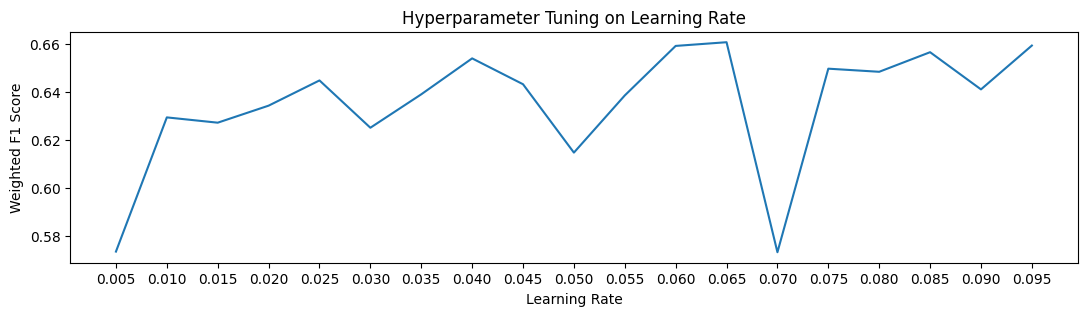

In [ ]:
plt.figure(figsize=(13,3))
plt.plot(learning_rate_list, weighted_f1_score_list)
plt.title('Hyperparameter Tuning on Learning Rate')
plt.xticks(learning_rate_list)
plt.xlabel("Learning Rate")
plt.ylabel("Weighted F1 Score")

For num epochs

454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
epochs:
 10
Neural Network Model Performance:
 0.5889680478627672
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
epochs:
 20
Neural Network Model Performance:
 0.5948047840117329
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
epochs:
 30
Neural Network Model Performance:
 0.6141219641692421
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
epochs:
 40
Neural Network Model Performance:
 0.6331324839461251
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
epochs:
 50
Neural Network Model Performance:
 0.632260602580057
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
epochs:
 60
Neural Network Model Performance:
 0.6414675076396792
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
epochs:
 70
Neural Network Model Performance:
 0.6474689974055378
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
epochs:
 80
Neural Network Model Performance:
 0.6428069258164872
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
epochs:
 90
Neural Network Model Performance:
 0.6578460198369044
454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/st

Text(0, 0.5, 'Weighted F1 Score')

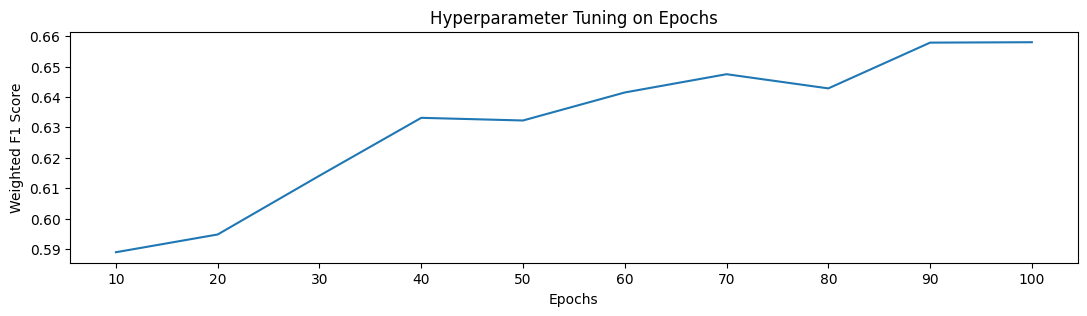

In [ ]:
# tunning epochs
epochs = 10
weighted_f1_score_list = []
epochs_list = []

while epochs < 101:

  model_tf = build_model(X_train_features.shape[1], 0.01)
  hist = model_tf.fit(x=X_train_features,
                  y=Y_train,
                  validation_data=[X_val_features, Y_val],
                  epochs=epochs, #kt 100 epochs
                  verbose=0)
  Y_pred = model_tf.predict(X_test_features)
  Y_pred = np.argmax(Y_pred, axis=1)
  score = classification_report(Y_test, Y_pred,output_dict=True)
  weighted_f1_score = score['weighted avg']['f1-score']
  weighted_f1_score_list.append(weighted_f1_score)
  epochs_list.append(epochs)
  print(f"epochs:\n {epochs}")
  print(f"Neural Network Model Performance:\n {weighted_f1_score}")
  epochs = epochs + 10



plt.figure(figsize=(13,3))
plt.plot(epochs_list, weighted_f1_score_list)
plt.title('Hyperparameter Tuning on Epochs')
plt.xticks(epochs_list)
plt.xlabel("Epochs")
plt.ylabel("Weighted F1 Score")

#### Used keras_tuner to help find optimal model (commented out since it runs for hours but kept for reference):

In [ ]:
# # using keras_tuner to help find best model
# def build_model(hp):
#     model = tf.keras.models.Sequential()

#     # create input layer
#     model.add(tf.keras.Input(shape=(X_train_features.shape[1],), name='Input'))

#     # hidden layers
#     for i in range(hp.Int('num_hidden_layers', 1, 3)):
#         model.add(tf.keras.layers.Dense(
#             units=hp.Int(f'units_hidden_{i}', min_value=3, max_value=30, step=3),
#             activation=hp.Choice(f'activation_hidden_{i}', values=['relu', 'tanh', 'sigmoid']),
#             name=f'Hidden{i}'
#         ))
#         model.add(tf.keras.layers.Dropout(
#             hp.Float(f'dropout_{i}', min_value=0, max_value=0.5, step=0.1),
#             name=f'Dropout_{i}'
#         ))

#     # create output layer
#     model.add(tf.keras.layers.Dense(
#         units=3,        # output dim - number of outcome classes if one-hot encoded
#         use_bias=True,               # use a bias (intercept) param
#         activation='softmax',
#         name='Output'
#     ))

#     # Compile model
#     model.compile(
#         optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     return model


In [ ]:
# !rm -rf ./untitled_project

In [ ]:
# # select tuner
# tuner = kt.Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs=100,
#     factor=3
# )


In [ ]:
# # search for optimal hyperparameters
# tuner.search(X_train_features, Y_train, epochs=50, validation_data=[X_val_features, Y_val])

#### Best keras_tuner tuned model (best overall NN model):

In [ ]:
# function to build model (Tuned with keras_tuner)
def build_model(num_features, learning_rate):
    """Build a TF linear regression model using Keras.

    Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """
    # This is not strictly necessary, but each time you build a model, TF adds
    # new nodes (rather than overwriting), so the colab session can end up
    # storing lots of copies of the graph when you only care about the most
    # recent.
    tf.keras.backend.clear_session()

    # Build a model using keras.Sequential.
    model = tf.keras.Sequential()

    # create input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'))

    # create hidden layer
    model.add(tf.keras.layers.Dense(
        units=15,        # number of hidden units
        use_bias=True,               # use a bias
        activation='tanh',
        name='Hidden1'
    ))

    # create dropout layer
    model.add(tf.keras.layers.Dropout(
            rate=0.4,
            name='Dropout1'
        ))

    # create hidden layer
    model.add(tf.keras.layers.Dense(
        units=30,        # number of hidden units
        use_bias=True,               # use a bias
        activation='relu',
        name='Hidden2'
    ))

    # create dropout layer
    model.add(tf.keras.layers.Dropout(
            rate=0.1,
            name='Dropout2'
        ))

    # create hidden layer
    model.add(tf.keras.layers.Dense(
        units=27,        # number of hidden units
        use_bias=True,               # use a bias
        activation='tanh',
        name='Hidden3'
    ))

    # create output layer
    model.add(tf.keras.layers.Dense(
        units=3,        # output dim - number of outcome classes
        use_bias=True,               # use a bias (intercept) param
        activation='softmax',
        name='Output'
    ))

    # optimizer Adam - default learning rate: 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    return model

#### Set learning rate and train NN model: (runs for ~8 min)

In [ ]:
# set learning rate
learning_rate = 0.001

# build model
model_tf = build_model(X_train_features.shape[1], learning_rate)

# train model
hist = model_tf.fit(x=X_train_features,
                y=Y_train,
                validation_data=[X_val_features, Y_val],
                epochs=100,
                verbose=0
)

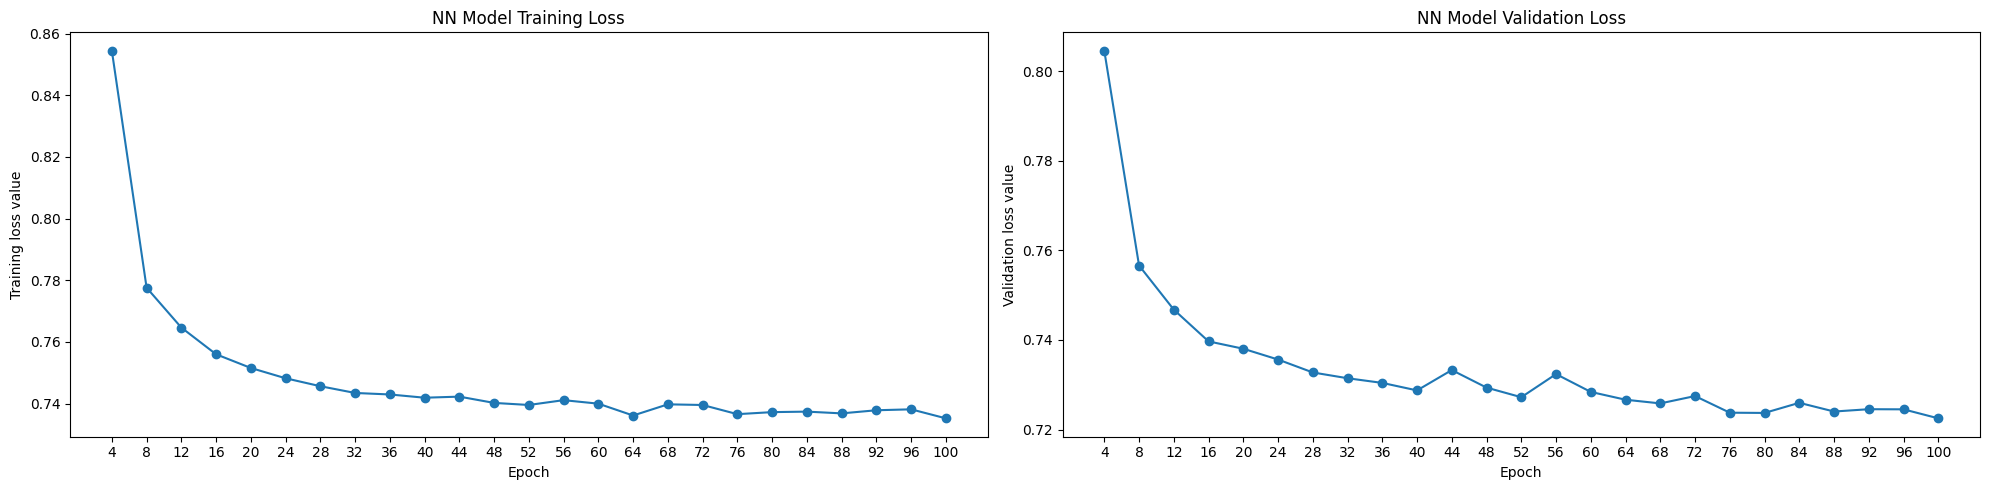

In [ ]:
# plot loss for training and validation
# epochs = range(1,101)
epochs = range(4, 101, 4)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
# training loss plot
axes[0].plot(epochs, hist.history['loss'][::4], '-o')
axes[0].set_ylabel('Training loss value')
axes[0].set_xticks(epochs)
axes[0].set_xlabel('Epoch')
axes[0].set_title('NN Model Training Loss')
# validation loss plot
axes[1].plot(epochs, hist.history['val_loss'][::4], '-o')
axes[1].set_ylabel('Validation loss value')
axes[1].set_xticks(epochs)
axes[1].set_xlabel('Epoch')
axes[1].set_title('NN Model Validation Loss')
plt.tight_layout()
plt.show()

In [ ]:
# get summary of nn model
model_tf.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Hidden1 (Dense)                      │ (None, 15)                  │             195 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout1 (Dropout)                   │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden2 (Dense)                      │ (None, 30)                  │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout2 (Dropout)                   │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden3 (Dense)                      │ (None, 27)                  │             837 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 3)                   │              84 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,790 (18.71 KB)

 Trainable params: 1,596 (6.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,194 (12.48 KB)

## Step 13: Model Analysis/Evaluation

#### RandomForest Ensemble Model Performance (Weighted F1 Score):

In [ ]:
# Make predictions on the test data
Y_pred = clf.predict(X_test_features)

# Evaluate the model's performance
score = classification_report(Y_test, Y_pred, digits=5)
print(f"RandomForest Ensemble Classification Model Performance:\n {score}")

RandomForest Ensemble Classification Model Performance:
               precision    recall  f1-score   support

           0    0.79262   0.77388   0.78313      4272
           1    0.78511   0.81048   0.79759      7767
           2    0.72394   0.68002   0.70129      2472

    accuracy                        0.77748     14511
   macro avg    0.76722   0.75479   0.76067     14511
weighted avg    0.77690   0.77748   0.77693     14511



#### RandomForest Model Confusion Matrix and ROC AUC plot

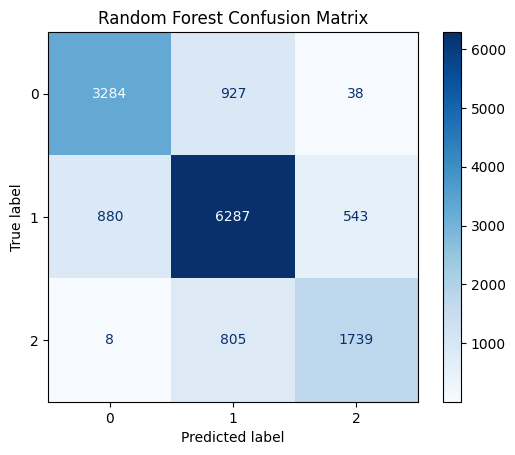

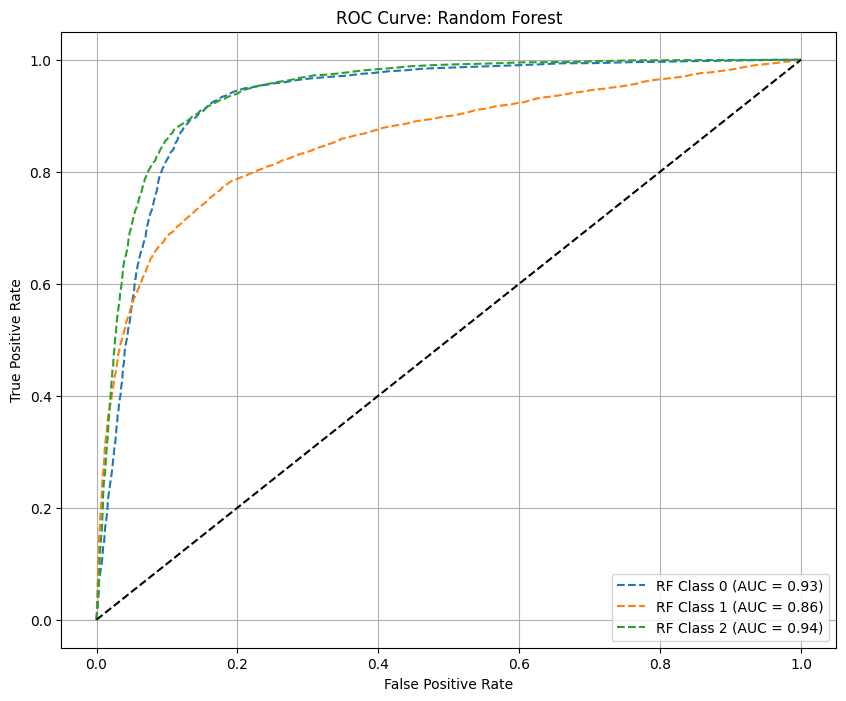

In [ ]:
# Get predictions
y_pred = clf.predict(X_test_features)

# Compute  confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()

# Generate probabilities for Random Forest model
rf_probs = clf.predict_proba(X_test_features)

# Compute ROC curve and AUC for each class
n_classes = rf_probs.shape[1]  # Assuming multi-class classification
fpr_rf, tpr_rf, roc_auc_rf = {}, {}, {}

for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(Y_test == i, rf_probs[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

# Plot the ROC curves for each model
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr_rf[i], tpr_rf[i], linestyle='--', label=f"RF Class {i} (AUC = {roc_auc_rf[i]:.2f})")

# Add plot labels and legend
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal for random guessing
plt.title("ROC Curve: Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

#### Keras_tuner Tuned Neural Network Model Performance (Weighted F1 Score):

In [ ]:
# get model predictions
Y_pred = model_tf.predict(X_test_features)
Y_pred = np.argmax(Y_pred, axis=1)

# compute f1 score for nn model
score = classification_report(Y_test, Y_pred, digits=5)
print(f"Neural Network Model Performance:\n {score}")

454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Neural Network Model Performance:
               precision    recall  f1-score   support

           0    0.72967   0.62172   0.67139      4272
           1    0.72030   0.71585   0.71807      7767
           2    0.49112   0.62621   0.55050      2472

    accuracy                        0.67287     14511
   macro avg    0.64703   0.65460   0.64665     14511
weighted avg    0.68402   0.67287   0.67578     14511



#### Tuned NN Model Confusion Matrix and ROC AUC plot

454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


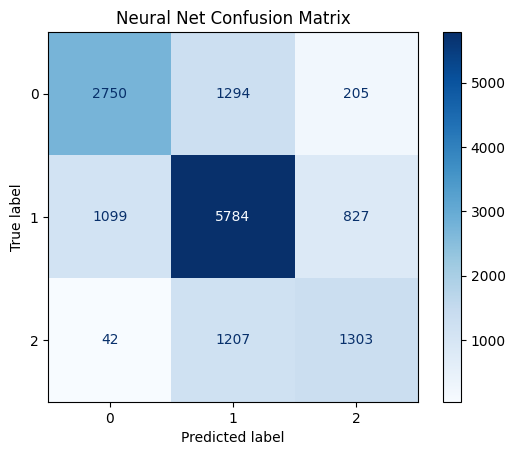

454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


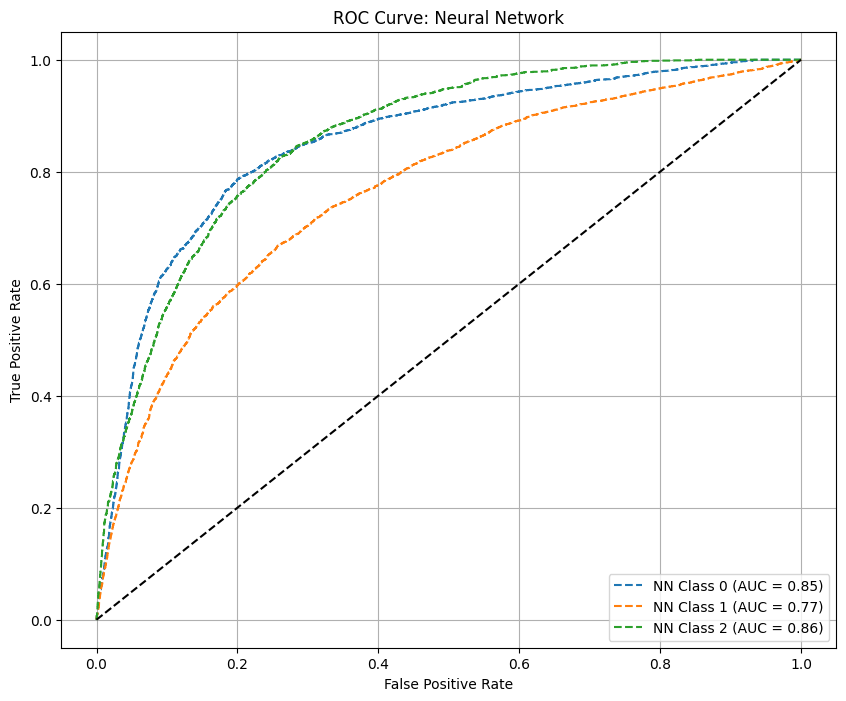

In [ ]:
# confusion matrix, ROC AUC curve for nn

# Get predictions
y_pred_probs = model_tf.predict(X_test_features)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to predicted classes

# Compute confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1', '2'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Neural Net Confusion Matrix")
plt.show()

# Generate probabilities for Neural Network model
nn_probs = model_tf.predict(X_test_features)

# Compute ROC curve and AUC for each class
n_classes = nn_probs.shape[1]  # Assuming multi-class classification
fpr_nn, tpr_nn, roc_auc_nn = {}, {}, {}

for i in range(n_classes):
    fpr_nn[i], tpr_nn[i], _ = roc_curve(Y_test == i, nn_probs[:, i])
    roc_auc_nn[i] = auc(fpr_nn[i], tpr_nn[i])

# Plot the ROC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr_nn[i], tpr_nn[i], linestyle='--', label=f"NN Class {i} (AUC = {roc_auc_nn[i]:.2f})")

# Add plot labels and legend
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal for random guessing
plt.title("ROC Curve: Neural Network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Code Sandbox (unofficial code - commented out so they don't run every time)

Wesley Model Start

In [ ]:
# # Define the target variable
# target_col = 'Credit_Utilization_Ratio'

# # Define the explicit predictors
# predictors = [
#     'Annual_Income',            # Continuous: Annual income
#     'Num_Bank_Accounts',        # Continuous: Number of bank accounts
#     'Num_Credit_Card',          # Continuous: Number of credit cards
#     'Interest_Rate',            # Continuous: Interest rate
#     'Num_of_Loan',              # Continuous: Number of loans
#     'Credit_History_Age',       # Continuous: Credit history in months
#     'Outstanding_Debt_clean',   # Continuous: Cleaned outstanding debt
#     'Total_EMI_per_month',      # Continuous: Monthly EMI payments
#     'Monthly_Balance'           # Continuous: Monthly balance
# ]

# # Drop rows with null values in predictors and target
# df_train = df_train.dropna(subset=predictors + [target_col])

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler

# # Target column
# target_col = 'Credit_Utilization_Ratio'

# # Ensure no nulls in predictors or target
# df_train = df_train.dropna(subset=predictors + [target_col])

# # Separate features and target
# X = df_train[predictors]
# y = df_train[target_col]

# # One-hot encode categorical variables
# X = pd.get_dummies(X, drop_first=True)

# # Train-test split (80-20 split for validation)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# # Normalize features
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)

Nancy's code

In [ ]:
# import tensorflow as tf
# from matplotlib import pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.utils import shuffle

In [ ]:
# # para to be predicted: Credit_Score (using 0.6,0.4,0.4 on training set),Delay_from_due_date_clean

# #variable that we chosen:
# #For Credit Score

# df_train = shuffle(df_train)
# X_df= df_train[[
#     #'Age',
#     'Annual_Income',
#     'Num_Bank_Accounts',
#     'Num_Credit_Card',
#     #'Interest_Rate',
#     'Num_of_Loan',
#     'Delay_from_due_date_clean',
#     'Num_of_Delayed_Payment_clean',
#     #'Changed_Credit_Limit_clean',
#     'Num_Credit_Inquiries',
#     #'Outstanding_Debt_clean',
#     #'Credit_Utilization_Ratio',
#     #'Credit_History_Age',
#     'Total_EMI_per_month',
#     #'Monthly_Balance'
#     ]]

# X = np.array(X_df.values)

# df_train['Credit_Score_clean'] = np.where(df_train['Credit_Score'] =="Good", 0, np.where(df_train['Credit_Score'] =="Standard", 1, 2))
# Y_df = df_train['Credit_Score_clean']

# Y = np.array(Y_df.values)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)


# print("shape of X_train:",X_train.shape)
# print("shape of Y_train:",Y_train.shape)


In [ ]:

# tf.keras.backend.clear_session()
# model_tf = tf.keras.Sequential()
# model_tf.add(tf.keras.layers.Dense(
#     units=3,                     # output dim
#     input_shape=[8],             # input dim
#     use_bias=False,              # we included the bias in X
#     activation='softmax',        # apply a sigmoid to the output
#     kernel_initializer=tf.ones_initializer,  # initialize params to 1
# ))
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)


# model_tf.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

# history = model_tf.fit(
#   x = X_train,
#   y = Y_train,
#   epochs=10,
#   batch_size=32,
#   verbose=1)

# #Show the loss (before the update) and the new weights.
# loss = history.history['loss']
# weights = model_tf.layers[0].get_weights()[0].T
# print('loss:', loss)


In [ ]:
# eph = list(range(1,11))
# print(eph)
# plt.plot(eph,loss)
# plt.title('Epoch number $ Loss Value')
# plt.xlabel('Epoch number')
# plt.ylabel('Loss Value')

In [ ]:
# # For Payment_Behaviour
# df_train[df_train['Payment_Behaviour']!= '!@9#%8']
# df_train['Credit_Score_clean'] = np.where(df_train['Credit_Score'] =="Good", 0, np.where(df_train['Credit_Score'] =="Standard", 1, 2))
# Y_df = df_train['Credit_Score_clean']

# df_train['Payment_Behaviour_clean'] = np.where(df_train['Payment_Behaviour'] =="High_spent_Small_value_payments", 0,\
#                                                np.where(df_train['Payment_Behaviour'] =='Low_spent_Large_value_payments', 1,\
#                                                         np.where(df_train['Payment_Behaviour'] =='Low_spent_Medium_value_payments', 2,\
#                                                                  np.where(df_train['Payment_Behaviour'] =='High_spent_Medium_value_payments', 3,4))))


# df_train['Payment_Behaviour_clean'].value_counts()

In [ ]:
# # para to be predicted: Payment_Behaviour_clean (using 0.7,0.3 on training set),Delay_from_due_date_clean

# #variable that we chosen:
# #For Credit Score

# df_train = shuffle(df_train)
# X_df= df_train[[
#     #'Age',
#     'Annual_Income',
#     'Num_Bank_Accounts',
#     'Num_Credit_Card',
#     #'Interest_Rate',
#     'Num_of_Loan',
#     'Delay_from_due_date_clean',
#     'Num_of_Delayed_Payment_clean',
#     #'Changed_Credit_Limit_clean',
#     'Num_Credit_Inquiries',
#     #'Outstanding_Debt_clean',
#     #'Credit_Utilization_Ratio',
#     #'Credit_History_Age',
#     'Total_EMI_per_month',
#     #'Monthly_Balance',
#     "Credit_Score_clean"
#     ]]

# X = np.array(X_df.values)

# Y_df = df_train['Payment_Behaviour_clean']

# Y = np.array(Y_df.values)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)


# print("shape of X_train:",X_train.shape)
# print("shape of Y_train:",Y_train.shape)


In [ ]:

# tf.keras.backend.clear_session()
# model_tf = tf.keras.Sequential()
# model_tf.add(tf.keras.layers.Dense(
#     units=5,                     # output dim
#     input_shape=[9],             # input dim
#     use_bias=False,              # we included the bias in X
#     activation='softmax',        # apply a sigmoid to the output
#     kernel_initializer=tf.ones_initializer,  # initialize params to 1
# ))
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)
# model_tf.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

# history = model_tf.fit(
#   x = X_train,
#   y = Y_train,
#   epochs=10,
#   batch_size=32,
#   verbose=1)

# #Show the loss (before the update) and the new weights.
# loss = history.history['loss']
# weights = model_tf.layers[0].get_weights()[0].T
# print('loss:', loss)

# eph = list(range(1,11))
# print(eph)
# plt.plot(eph,loss)
# plt.title('Epoch number $ Loss Value')
# plt.xlabel('Epoch number')
# plt.ylabel('Loss Value')


In [ ]:
# history.history

In [ ]:
# results = model_tf.evaluate(X_test, Y_test, verbose=0)
# print(results)
# results = model_tf.evaluate(X_train, Y_train, verbose=0)
# print(results)

In [ ]:
# print(f'Processed training data shape: {df_cred_score.shape}')
# print(f'Processed training data shape: {df_cred_score.columns}')

In [ ]:
##Nancy's Code

In [ ]:

# X_df = df_cred_score[[
#     'Age',
#     'Annual_Income',
#     'Num_Bank_Accounts',
#     'Num_Credit_Card',
#     'Interest_Rate',
#     'Num_of_Loan',
#     'Delay_from_due_date_clean',
#     'Num_of_Delayed_Payment_clean',
#     'Changed_Credit_Limit_clean',
#     'Num_Credit_Inquiries',
#     'Outstanding_Debt_clean',
#     'Credit_Utilization_Ratio',
#     'Credit_History_Age',
#     'Total_EMI_per_month',
#     'Payment_Behaviour_clean',
#     'Monthly_Balance'
#     ]]


# X = np.array(X_df.values)
# Y_df = df_cred_score['Credit_Score_encoded']

# Y = np.array(Y_df.values)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)


In [ ]:
# print(X_train.shape,Y_train.shape)

In [ ]:
# Target_feature = 'Credit_Score_encoded'

In [ ]:
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Dense(units=1, input_dim=X_train.shape[1], activation='sigmoid'))
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# info = model.fit(X_train, Y_train, epochs=30, batch_size=100, verbose=0, validation_data=(X_test, Y_test))

In [ ]:
# accuracy = model.evaluate(X_train, Y_train, verbose=0)[1]
# val_accuracy = model.evaluate(X_test, Y_test, verbose=0)[1]

# print(accuracy,val_accuracy)

In [ ]:
# col = X_df.columns
# weights = np.abs(model.layers[0].get_weights()[0].flatten())
# weights_df = pd.DataFrame({'feature': col, 'weight': weights}).sort_values(by='weight', ascending=False)
# print(weights_df)

# # 4                  Interest_Rate  0.871441
# # 6      Delay_from_due_date_clean  0.766658
# # 8     Changed_Credit_Limit_clean  0.743360
# # 12            Credit_History_Age  0.421453
# # 2              Num_Bank_Accounts  0.395286
# # 14       Payment_Behaviour_clean  0.337178
# # 5                    Num_of_Loan  0.312145

In [ ]:
# #model = tf.keras.Sequential()
# #model.add(tf.keras.layers.Dense(units=1, input_dim=X_train.shape[1], activation='sigmoid'))
# #model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


# model_tf = tf.keras.Sequential()
# model_tf.add(tf.keras.layers.Dense(
#     units=3,                     # output dim
#     input_shape=[16],             # input dim
#     use_bias=False,              # we included the bias in X
#     activation='softmax',        # apply a sigmoid to the output
#     kernel_initializer=tf.ones_initializer,  # initialize params to 1
# ))
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

# model_tf.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
# info = model_tf.fit(X_train, Y_train, epochs=30, batch_size=100, verbose=0, validation_data=(X_test, Y_test))



In [ ]:
# accuracy = model_tf.evaluate(X_train, Y_train, verbose=0)[1]
# val_accuracy = model_tf.evaluate(X_test, Y_test, verbose=0)[1]

# print(accuracy,val_accuracy)

# col = X_df.columns
# arr = model_tf.layers[0].get_weights()[0]
# arr = np.abs(arr)
# weights = np.sum(arr, axis=1)
# print(weights)
# weights_df = pd.DataFrame({'feature': col, 'weight': weights}).sort_values(by='weight', ascending=False)
# print(weights_df)

In [ ]:
# 8     Changed_Credit_Limit_clean  1473.970825
# 9           Num_Credit_Inquiries   625.394653
# 11      Credit_Utilization_Ratio   280.639648
# 12            Credit_History_Age   220.769638
# 7   Num_of_Delayed_Payment_clean   216.746735
# 6      Delay_from_due_date_clean   202.037476
# 4                  Interest_Rate   157.252045
# 2              Num_Bank_Accounts   124.279037
# 0                            Age   120.840996

In [ ]:
# # Using one dimension result

# X_df_top_feature1 = df_cred_score[[
#     'Interest_Rate',
#     'Delay_from_due_date_clean',
#     'Changed_Credit_Limit_clean',
#     'Credit_History_Age',
#     'Num_Bank_Accounts',
#     'Payment_Behaviour_clean',
#     'Num_of_Loan'
#     ]]


# # using 3 dim output classification training

# # Using one dimension result

# X_df_top_feature2 = df_cred_score[[
#     'Changed_Credit_Limit_clean',
#     'Num_Credit_Inquiries',
#     'Credit_Utilization_Ratio',
#     'Credit_History_Age',
#     'Num_of_Delayed_Payment_clean',
#     'Delay_from_due_date_clean',
#     'Interest_Rate',
#     'Num_Bank_Accounts',
#     'Age'
#     ]]


# X_top_feature1 = np.array(X_df_top_feature1.values)
# Y_df = df_cred_score['Credit_Score_encoded']
# Y = np.array(Y_df.values)
# X_train_f1, X_test_f1, Y_train, Y_test = train_test_split(X_top_feature1, Y, test_size=0.3)


# X_top_feature2 = np.array(X_df_top_feature2.values)

# X_train_f2, X_test_f2, Y_train, Y_test = train_test_split(X_top_feature2, Y, test_size=0.3)

In [ ]:
# model_tf_f1 = tf.keras.Sequential()
# model_tf_f1.add(tf.keras.layers.Dense(
#     units=3,                     # output dim
#     input_shape=[7],             # input dim
#     use_bias=False,              # we included the bias in X
#     activation='softmax',        # apply a sigmoid to the output
#     kernel_initializer=tf.ones_initializer,  # initialize params to 1
# ))
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

# model_tf_f1.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
# info = model_tf_f1.fit(X_train_f1, Y_train, epochs=15, batch_size=64, verbose=1, validation_data=(X_test_f1, Y_test))


# accuracy = model_tf_f1.evaluate(X_train_f1, Y_train, verbose=0)[1]
# val_accuracy = model_tf_f1.evaluate(X_test_f1, Y_test, verbose=0)[1]

# print(accuracy,val_accuracy)

In [ ]:
# model_tf_f2 = tf.keras.Sequential()
# model_tf_f2.add(tf.keras.layers.Dense(
#     units=3,                     # output dim
#     input_shape=[9],             # input dim
#     use_bias=False,              # we included the bias in X
#     activation='softmax',        # apply a sigmoid to the output
#     kernel_initializer=tf.ones_initializer,  # initialize params to 1
# ))
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

# model_tf_f2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
# info = model_tf_f2.fit(X_train_f2, Y_train, epochs=30, batch_size=32, verbose=1, validation_data=(X_test_f2, Y_test))


# accuracy = model_tf_f2.evaluate(X_train_f2, Y_train, verbose=0)[1]
# val_accuracy = model_tf_f2.evaluate(X_test_f2, Y_test, verbose=0)[1]

# print(accuracy,val_accuracy)

In [ ]:
# accuracy = model_tf_f2.evaluate(X_train_f2, Y_train, verbose=0)[1]
# val_accuracy = model_tf_f2.evaluate(X_test_f2, Y_test, verbose=0)[1]

# print(accuracy,val_accuracy)

In [ ]:
# model_tf_f2 = tf.keras.Sequential()
# model_tf_f2.add(tf.keras.layers.Dense(
#     units=3,                     # output dim
#     input_shape=[9],             # input dim
#     use_bias=False,              # we included the bias in X
#     activation='softmax',        # apply a sigmoid to the output
#     kernel_initializer=tf.ones_initializer,  # initialize params to 1
# ))
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# model_tf_f2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
# info = model_tf_f2.fit(X_train_f2, Y_train, epochs=100, batch_size=32, verbose=0, validation_data=(X_test_f2, Y_test))


# accuracy = model_tf_f2.evaluate(X_train_f2, Y_train, verbose=0)[1]
# val_accuracy = model_tf_f2.evaluate(X_test_f2, Y_test, verbose=0)[1]

# print(accuracy,val_accuracy)

In [ ]:
# model_tf_f3 = tf.keras.Sequential()

# model_tf_f3.add(tf.keras.Input(shape=[9], name='Input'))
# model_tf_f3.add(tf.keras.layers.Dense(
#     units=100,        # number of hidden units
#     use_bias=True,               # use a bias
#     activation='relu',
#     kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
#     bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
#     name='Hidden_layer'
# ))
# model_tf_f3.add(tf.keras.layers.Dense(
#     units=50,        # number of hidden units
#     use_bias=True,               # use a bias
#     activation='relu',
#     kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
#     bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
#     name='Hidden_layer2'
# ))

# model_tf_f3.add(tf.keras.layers.Dense(
#     units=20,        # number of hidden units
#     use_bias=True,               # use a bias
#     activation='relu',
#     kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
#     bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
#     name='Hidden_layer3'
# ))

# model_tf_f3.add(tf.keras.layers.Dense(
#     units=3,        # output dim
#     use_bias=True,               # use a bias (intercept) param
#     activation='softmax',
#     kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
#     bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
#     name='Output'
# ))

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# model_tf_f3.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
# info = model_tf_f3.fit(X_train_f2, Y_train, epochs=200, batch_size=32, verbose=1, validation_data=(X_test_f2, Y_test))


# accuracy = model_tf_f3.evaluate(X_train_f2, Y_train, verbose=0)[1]
# val_accuracy = model_tf_f3.evaluate(X_test_f2, Y_test, verbose=0)[1]

# print(accuracy,val_accuracy)






In [ ]:
# accuracy = model_tf_f3.evaluate(X_train_f2, Y_train, verbose=0)[1]
# val_accuracy = model_tf_f3.evaluate(X_test_f2, Y_test, verbose=0)[1]

# print(accuracy,val_accuracy)

In [ ]:
# loss = info.history['loss']
# weights = model_tf_f3.layers[0].get_weights()[0].T
# print('loss:', loss)

# eph = list(range(1,101))
# print(eph)
# plt.plot(eph,loss)
# plt.title('Epoch number $ Loss Value')
# plt.xlabel('Epoch number')
# plt.ylabel('Loss Value')


In [ ]:
# wesley_df_train = df_train[[
#     'Age10',
#     # 'Occupation',
#     'Annual_Income',
#     'Num_Bank_Accounts',
#     'Num_Credit_Card',
#     'Interest_Rate',
#     'Num_of_Loan',
#     # 'Delay_from_due_date_clean',
#     # 'Num_of_Delayed_Payment_clean',
#     # 'Changed_Credit_Limit_clean',
#     # 'Num_Credit_Inquiries',
#     'Credit_Mix',
#     # 'Outstanding_Debt_clean',
#     # 'Credit_Utilization_Ratio',
#     # 'Credit_History_Age',
#     # 'Total_EMI_per_month',
#     # 'Amount_invested_monthly',
#     # 'Payment_Behaviour',
#     'Monthly_Balance',
#     'Credit_Score'
#     ]]

# wesley_df_train = wesley_df_train[df_train.Credit_Mix !='_']
# wesley_df_train.dtypes

In [ ]:
# wesley_df_train

In [ ]:
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, accuracy_score
# # list the columns that should be kept in the brackets
# # please mark the columns that you recommend dropping in the spreadsheet
# # and if you converted an existing column into different structure ie one-hot encoding or embedding

# # Credit_Score column excluded for now since it's only in training set
# # columns that are commented out need to be converted to numeric and/or one-hot encoded
# # Changed_Credit_Limit_clean had error when running processing, so removed for now


# wesley_df_train=wesley_df_train.dropna()
# wesley_df_train = wesley_df_train.sample(frac=0.25, random_state=42)
# # Separate features and target
# X = wesley_df_train.drop('Credit_Score', axis=1)  # Features
# y = wesley_df_train['Credit_Score']  # Target

# # Identify categorical and numerical columns
# categorical_columns = [ #   'Delay_from_due_date_clean',
#     # 'Num_of_Delayed_Payment_clean',
#     # 'Changed_Credit_Limit_clean',
#     # 'Num_Credit_Inquiries',
#     'Credit_Mix',
#     # 'Outstanding_Debt_clean',
#     # 'Credit_Utilization_Ratio',
#     # 'Credit_History_Age',
#     # 'Total_EMI_per_month',
#     # 'Amount_invested_monthly'
#     'Age10']
# numerical_columns = [col for col in X.columns if col not in categorical_columns]

# # Preprocessing for categorical features
# for col in categorical_columns:
#     X[col] = X[col].astype(str)

# encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # handle_unknown='ignore' for safety
# categorical_encoded = encoder.fit_transform(X[categorical_columns])
# categorical_encoded_df = pd.DataFrame(
#     categorical_encoded,
#     columns=encoder.get_feature_names_out(categorical_columns)
# )

# # Preprocessing for numerical features
# scaler = StandardScaler()
# numerical_scaled = scaler.fit_transform(X[numerical_columns])
# numerical_scaled_df = pd.DataFrame(numerical_scaled, columns=numerical_columns)

# # Combine processed categorical and numerical features
# X_processed = pd.concat([numerical_scaled_df.reset_index(drop=True), categorical_encoded_df.reset_index(drop=True)], axis=1)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


In [ ]:
# # Train a Random Forest Classifier
# model = RandomForestClassifier(max_features='sqrt', random_state=42)
# model.fit(X_train, y_train)

# # Predict on the test set
# y_pred = model.predict(X_test)

# # Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:")
# print(classification_report(y_test, y_pred))

# # Optional: Feature Importance (if you want to interpret the model)
# feature_importances = pd.Series(model.feature_importances_, index=X_processed.columns)
# print("Top 10 Important Features:")
# print(feature_importances.nlargest(10))

Eun-Hae's code

In [ ]:
# # Create copies to avoid modifying originals
# X_train_recoded = X_train.copy()
# X_val_recoded = X_val.copy()

# # Store cutoff points for each feature
# cutoffs = {}

# # First pass: Calculate cutoff points from X_train
# for col in continuous_features:
#     if col in X_train.columns:
#         # Calculate quintile bins and store bin edges
#         _, bin_edges = pd.qcut(X_train[col], q=5, retbins=True)
#         cutoffs[col] = bin_edges

#         # Print the bin edges for reference
#         print(f"\nBin edges for {col}:")
#         for i, edge in enumerate(bin_edges[:-1]):
#             print(f"Bin {i}: {edge:.2f} to {bin_edges[i+1]:.2f}")

# # Second pass: Apply cutoffs to both X_train and X_val
# for col in continuous_features:
#     if col in X_train.columns:
#         # Recode X_train
#         X_train_recoded[col] = pd.cut(X_train[col],
#                                      bins=cutoffs[col],
#                                      labels=False)

#         # Recode X_val using same cutoffs
#         X_val_recoded[col] = pd.cut(X_val[col],
#                                    bins=cutoffs[col],
#                                    labels=False)

#         # Handle any out-of-range values in validation set
#         X_val_recoded[col] = X_val_recoded[col].fillna(method='bfill')

In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# # Initialize the OneHotEncoder with drop='first' to avoid multicollinearity
# ohe = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')

# # Fit the encoder on X_train_recoded
# ohe.fit(X_train_recoded)

# # Transform X_train_recoded and X_val_recoded using the fitted encoder
# X_train_encoded = ohe.transform(X_train_recoded)
# X_val_encoded = ohe.transform(X_val_recoded)

# # Convert the transformed arrays to DataFrames
# train_columns = ohe.get_feature_names_out(X_train_recoded.columns)
# X_train_recoded = pd.DataFrame(X_train_encoded, columns=train_columns, index=X_train_recoded.index)

# val_columns = ohe.get_feature_names_out(X_val_recoded.columns)
# X_val_recoded = pd.DataFrame(X_val_encoded, columns=val_columns, index=X_val_recoded.index)

# # Check the results
# print("One-hot encoded training set:")
# print(X_train_recoded.head())

# print("\nOne-hot encoded validation set:")
# print(X_val_recoded.head())

In [ ]:
# # 1. basline
# ## identify majority class (majority class is 1)
# print(Y_train.value_counts().reset_index())
# ## convert Y_train to int
# Y_train=Y_train.astype("int")
# Y_hat_baseline=[1]*len(Y_train)
# ## accuracy
# print("Accuracy (train):\n",(Y_train==Y_hat_baseline).sum()/len(Y_train))
# # 2. cross entropy loss
# ## define function
# def ce_loss(preds, Y):
#   """
#     preds are (m,n) m = number of examples, n = number of classes
#     Y is (m,) -- array of sparse labels
#     preds[0] = [.1, .1, .8] Y[0] = 2 Y_dense[0] = [0, 0, 1]
#   """
#   # Get the number of examples
#   m = Y.shape[0]

#   # Compute the first sum, the cross-entropy for each example, using
#   # the rows of the predictions and corresponding labels.
#   # Note that we need the dense (one-hot) labels.
#   Y_dense = tf.keras.utils.to_categorical(Y)
#   a=1e-16
#   preds = np.clip(preds, a, 1-4*a)  # to avoid log(0)
#   # [.1, .1, .8] [0, 0, 1] -> [0, 0, -1*log(.8)] -> -1*log(.8)
#   cross_entropy_values = - np.sum(Y_dense * np.log(preds), axis=1)

#   # Sum the per-example cross-entropy values.
#   loss = np.sum(cross_entropy_values) / m

#   return loss

# Y_hat_baseline_cat=np.tile(np.array([0., 1., 0]), (len(Y_train),1))
# print("loss (train):\n", ce_loss(Y_hat_baseline_cat,Y_train))
# Y_hat_baseline_val_cat=np.tile(np.array([0., 1., 0.]), (len(Y_val),1))
# print("loss (val):\n", ce_loss(Y_hat_baseline_val_cat,Y_val))

In [ ]:
# def build_model(num_features, learning_rate):
#   """Build a TF linear regression model using Keras.

#   Args:
#     num_features: The number of input features.
#     learning_rate: The desired learning rate for SGD.

#   Returns:
#     model: A tf.keras model (graph).
#   """

#   tf.keras.backend.clear_session()
#   tf.random.set_seed(0)

#   # Build a model using keras.Sequential. While this is intended for neural
#   # networks (which may have multiple layers), we want just a single layer for
#   # binary logistic regression.
#   model = tf.keras.Sequential()
#   model.add(tf.keras.layers.Dense(
#       units=5,        # output dim
#       input_shape=[num_features],  # input dim
#       use_bias=True,
#       activation="softmax",
#       kernel_initializer=tf.ones_initializer,  # initialize params to 1
#       bias_initializer=tf.ones_initializer
#   ))

#   optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

#   # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
#   model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

#   # return model

In [ ]:
# tf.random.set_seed(0)
# # Build and compile model
# model_tf=build_model(70, 0.001)
# # train model
# history = model_tf.fit(
#   x = X_train.values,
#   y = Y_train.values,
#   validation_data=(X_val.values, Y_val.values),
#   epochs=10,
#   batch_size=32
# )

In [ ]:
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss)+1)

# plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# train_preds = model_opt.predict(X_train.values)
# train_preds_labels = np.argmax(train_preds, axis=1)
# accuracy_train = np.mean(train_preds_labels == Y_train.values)
# print("Accuracy (train):/n",accuracy_train)
# test_preds = model_opt.predict(X_test.values)
# test_preds_labels = np.argmax(test_preds, axis=1)
# accuracy_test = np.mean(test_preds_labels == Y_test.values)
# print("Accuracy (test):/n",accuracy_test)